#### Auszuführen mit Environment "tf"

#### Importe & Definitionen

In [1]:
import tensorflow as tf
from keras import backend as K
import tifffile
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import json
import csv
import random
from time import time
import shutil

# Definition des Data-Generators
class CustomDataGenerator(tf.keras.utils.Sequence):
 
    def __init__(self, batch_size, img_directory, msk_directory, shuffle= False, augment= False):
        self.batch_size = batch_size
        self.img_directory = img_directory
        self.msk_directory = msk_directory
        self.list_img_IDs = os.listdir(self.img_directory)
        self.list_msk_IDs = os.listdir(self.msk_directory)
        self.shuffle = shuffle
        self.augment = augment

    def augment_data(self, x, y):     
        x_flip = x
        y_flip = y

        # zufällige horizontale & vertikale Flips
        horiz = random.randint(0, 9)
        if horiz <= 4:
            x_flip = np.fliplr(x)
            y_flip = np.fliplr(y)

        vert = random.randint(0, 9)
        if vert <= 4:
            x_flip = np.flipud(x_flip)
            y_flip = np.flipud(y_flip)
        
        return x_flip, y_flip

    def __len__(self):

        return len(os.listdir(self.img_directory)) // self.batch_size
    
    def __getitem__(self, index):
        batch_img_IDs = self.list_img_IDs[index*self.batch_size : (index+1)*self.batch_size]
        batch_msk_IDs = self.list_msk_IDs[index*self.batch_size : (index+1)*self.batch_size]

        images = []
        masks = []
        for img_id, msk_id in zip(batch_img_IDs, batch_msk_IDs):
            # einlesen Bild
            img_path = os.path.join(self.img_directory, img_id)
            with open(img_path, 'rb') as f:
                image = tifffile.imread(f)

            # Transformation in "channels_last"-Format
            image = np.moveaxis(image, 0, -1)
            
            # einlesen Maske
            msk_path = os.path.join(self.msk_directory, msk_id)
            with open(msk_path, 'rb') as f:
                mask = tifffile.imread(f)

            # Erstellen einer zusätzlichen Achse um Tensor-Dimension zu erreichen
            mask = mask[:, :, np.newaxis]

            # Data Augmentation
            if self.augment:
                image, mask = self.augment_data(image, mask)

            # Skalierung der Werte
            images.append((image / 127.5) - 1)
            masks.append(mask/255)
        
        return (np.array(images), np.array(masks))
    
    def on_epoch_end(self):
        if self.shuffle:
            a = self.list_img_IDs
            b = self.list_msk_IDs

            c = list(zip(a, b))

            random.shuffle(c)

            self.list_img_IDs, self.list_msk_IDs = zip(*c)


# Definition des Dice-Koeffizienten
def Dice_coefficient(y_true, y_pred, smooth=10e-6):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


# Ableitung einer zu minimierenden Loss-Funktion aus Dice-Koeffzient
def Dice_loss(y_true, y_pred):
    return 1 - Dice_coefficient(y_true, y_pred)


# Rückgängig machen der Normalisierung zur korrekten Anzeige der Bilder
def reverse_scaling(image):
    return (((image + 1) / 2 )* 255).astype(np.uint8)


def load_model(model_type):
    # Speicherpfade der verschiedenen Architekturen
    model_dict = {
        'BN': './model_config_files/conf.json',
        'CONV': './model_config_files/conf_RGB_addConv3.json',
        'SPLIT': './model_config_files/conf_splitRGB.json'
        }

    # Auswahl der Architektur entsprechend der verwendeten Variante
    path = model_dict[model_type]

    # Laden der JSON
    with open(path, 'r', encoding='utf-8') as f:
        new_conf = json.load(f)

    # Laden des Modells aus JSON
    unet = tf.keras.Model().from_config(new_conf)

    # Wo die shape der Gewichte des Layers es zulässt, werden immer die selben zufällig initialisierten Gewichte verwendet
    random_path = './saved_weights/unet_resnet50v2_random.npy'

    # entsprechend der Variante müssen Gewichte unterschiedlich gesetzt werden
    if model_type == 'BN':
        loaded_weights = np.load(random_path, allow_pickle= True)
        unet.set_weights(loaded_weights)


    elif model_type == 'CONV':
        # zufällige Gewichte des neu erstellten U-Nets
        unet_weights = unet.get_weights()

        # gespeicherte zufällige Gewichte für den einheitlichen Decoder-Teil des U-Nets
        loaded_weights = np.load(random_path, allow_pickle= True)

        # Leere Liste für neue Gewichte
        updated_weights = []

        # kernel und bias Gewichte des zusätzlichen Convolution-layer
        for i in range(2):
            updated_weights.append(unet_weights[i])

        # einfügen aller weiteren Gewichte
        for unet_w, loaded_w in zip(unet_weights[2:], loaded_weights):
            # für den 2. Convolution-layer passt die shape nicht, bleibt daher unberührt
            if unet_w.shape != loaded_w.shape:
                updated_weights.append(unet_w)

            # alle anderen werden durch die geladenen ersetzt
            else:
                updated_weights.append(loaded_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)

    elif model_type == 'SPLIT':
        # zufällige Gewichte des neu erstellten U-Nets
        unet_weights = unet.get_weights()

        # gespeicherte zufällige Gewichte für den einheitlichen Decoder-Teil des U-Nets
        loaded_weights = np.load(random_path, allow_pickle= True)

        # Leere Liste für neue Gewichte
        updated_weights = []

        # kernel und bias Gewichte des zusätzlichen Convolution-layer
        for i in range(4):
            updated_weights.append(unet_weights[i])

        # einfügen aller weiteren Gewichte
        for unet_w, loaded_w in zip(unet_weights[4:], loaded_weights[2:]):
            # für den 2. Convolution-layer passt die shape nicht, bleibt daher unberührt
            if unet_w.shape != loaded_w.shape:
                updated_weights.append(unet_w)

            # alle anderen werden durch die geladenen ersetzt
            else:
                updated_weights.append(loaded_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)

    return unet

def set_dropout(unet, rgb_drop, ir_drop):
    rgb_names = ['dropout_r', 'dropout_g', 'dropout_b']
    ir_name = 'dropout_ir'

    for layer in unet.layers:
        if layer.name in rgb_names:
            layer.rate = rgb_drop

        if layer.name in ir_name:
            layer.rate = ir_drop


def set_weight_decay(unet, l1, l2):
    regularizer = tf.keras.regularizers.L1L2(l1= l1, l2= l2)

    for layer in unet.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer.kernel_regularizer = regularizer


def mean_of_RGB_weights(weights):
  # Mittelwert entlang der Kanal-Achse (=-2)
  mean_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
  # Squeeze um Kanalachse = 1 zu kollabieren
  mean_weights = np.squeeze(mean_weights, axis= -2)
  return(mean_weights)
  
def set_pretrained_weights(unet, option):
    unet = unet
    unet_weights = unet.get_weights()

    # Laden der Gewichte des vortrainierten ResNet aus Keras
    RGB_weights_path = './saved_weights/orig_resnet50v2_imagenet_weights.npy'
    saved_weights = np.load(RGB_weights_path, allow_pickle= True)

    # Abschneiden der Classifier-Gewichte
    saved_weights = saved_weights[:-2]


    # Übernehmen der RGB Gewichte für 1. Convolution-layer, IR Gewichte Mittelwert aus RGB
    if option == 'AVG':
        # Gewichte setzen für den Encoder-Teil:
        for i, layer in enumerate(unet_weights):
            # Ende des Encoder-Teils
            if i == len(saved_weights):
                break
            
            # 1. Conv-layer ist i=0
            if i == 0:
                layer[:,:, 3, :] = mean_of_RGB_weights(saved_weights[i])
                layer[:,:, 0:3, :] = saved_weights[i][...]

            # alle anderen Gewichte können übernommen werden
            else:
                layer[...] = saved_weights[i][...]
                
        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(unet_weights)


    # Übernehmen der RGB Gewichte für 1. Convolution-layer, IR Gewichte zufällig
    if option == 'RNDM':
        # Leere Liste für aktualisierte Gewichte
        updated_weights = []

        # Iterieren über geladene Gewichte und zufällige
        for unet_w, loaded_w in zip(unet_weights, saved_weights):
            # Für 1. Conv-Layer stimmt shape nicht überein
            if (unet_w.shape != loaded_w.shape):
                new_weights = unet_w
                # Gewichte für RGB-Channel werden übernommen, IR bleibt wie er ist
                new_weights[:,:, 0:3, :] = loaded_w
                updated_weights.append(new_weights)

            # alle anderen shapes stimmen überein und können übernommen werden
            else:
                updated_weights.append(loaded_w)

        # hinzufügen der zufälligen Gewichte des Decoder-parts
        for unet_w in unet_weights[len(saved_weights):]:
            updated_weights.append(unet_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)


    # Zusätzlicher Convolution-Layer vor Encoder
    if option == 'RGB':
        # Gewichte setzen für den Encoder-Teil:
        # Beginn ab i=2 durch eingeschobenen Conv-Layer, bis Bottleneck i=269+2
        for i, layer in enumerate(unet_weights):
            if 2 <= i <= 269+2:
                layer[...] = saved_weights[i-2][...]
                
        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(unet_weights)


    # seperate Convolution Layer für RGB und IR
    if option == 'RGB_SPLIT':
        loaded = np.load('./saved_weights/orig_resnet50v2_imagenet_weight_paths.npy', allow_pickle= True)
        loaded = loaded[()]

        # Leere Liste für aktualisierte Gewichte
        updated_weights = []

        # Liste mit Layernamen die später übersprungen werden
        skip_BN = ['conv2_block1_preact_bn.gamma', 'conv2_block1_preact_bn.beta', 'conv2_block1_preact_bn.moving_mean', 'conv2_block1_preact_bn.moving_variance']

        # Iteriere über Layer des Modells
        for l in unet.layers:
            # Falls Gewichte vorhanden für diesen Layer, iteriere über diese   
            if (len(l.weights) > 0):
                for w in l.weights:
                    try:
                        # standardisieren der Layernamen aus layer.weigths und model.get_weigths
                        w_name = w.name.replace('/', '.')[:-2]
                        # durch die beiden Convolutional-Layer verdoppelt sich auch die Anzahl der BN-Gewichte, diese können daher nicht übernommen werden
                        if w_name in skip_BN:
                            updated_weights.append(w)
                            #print(w.name, "not replaced")

                        # für die übrigen Layer werden die Gewichte übernommen, sofern der Layername im Dict vorhanden ist                                    
                        else:
                            updated_weights.append(loaded[w_name])
                            #print(w.name, 'replaced')

                    # ansonsten kommt es zu einer Fehlermeldung und es bleibt es bei den zufälligen Gewichten
                    except KeyError as e:
                        updated_weights.append(w)
                        #print(w.name, "not replaced")

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)


def set_encoder_frozen(unet, pretrained_weights, train_first_layer= False):
    unet.trainable = True

    # Falls RGB und IR in seperaten Conv-Layern wird RGB immer eingefroren, IR nicht
    if pretrained_weights == 'AVG' or pretrained_weights == 'RNDM':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if train_first_layer and layer.name == 'conv1_conv':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False


    if pretrained_weights == 'EXTRA_CONV':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if layer.name == 'conv0_conv':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False



    if pretrained_weights == 'RGB_SPLIT':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if layer.name == 'conv1_conv_ir':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False

            # beim Split sind für erstes BN keine Gewichte vorhanden, daher trainierbar und Einfrieren danach
            if layer.name == 'conv2_block1_preact_bn':
                layer.training = True
                #freeze_start = True
                continue



def set_trainable_fine_tuning(unet, pretrained_weights, train_first_layer= False):
    # Anzahl der trainierbaren Encoder Layer, durch Versuchsreihe bestimmt
    train_encoder_layers= 27

    # Encoder bleibt größtenteils eingefroren
    set_encoder_frozen(unet, pretrained_weights, train_first_layer)

    # Falls RGB und IR in seperaten Conv-Layern wird RGB immer eingefroren, IR nicht
    #if pretrained_weights in ['AVG', 'RNDM']:

    # Für das Fine-Tuning werden Top_layer des Encoder-Parts wieder trainable geschaltet
    freeze_encoder = False
    countdown = int(train_encoder_layers)
    
    # dafür werden die Layer jetzt rückwärts durchlaufen
    for layer in reversed(unet.layers):
        # ab dem Bottleneck beginnt der Encoder-part
        if layer.name == 'up_sampling2d':
            freeze_encoder = True

        # für train_encoder_layers (int) werden Layer trainierbar
        if freeze_encoder and countdown >= 0:
            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = True        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False

            countdown -= 1


def compile_model(unet, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)

    #loss = tf.keras.losses.BinaryFocalCrossentropy(gamma= 2.0, name= 'binary_focal_crossentropy')
    loss = Dice_loss

    binary_iou = tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5),
    metrics = [
        'accuracy',
        binary_iou,
        tf.keras.metrics.TruePositives(name='true_positives'),
        tf.keras.metrics.FalsePositives(name='false_positives'),
        tf.keras.metrics.TrueNegatives(name='true_negatives'),
        tf.keras.metrics.FalseNegatives(name='false_negatives'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    unet.compile(optimizer= optimizer, loss= loss, metrics= metrics)


def get_callbacks(model_name, output_folder_prefix, do_early_stop):
    checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'
    logger_path = f'../output/{output_folder_prefix}_logger/{model_name}'

    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_binary_iou',
        mode= 'max',
        save_weights_only=False,
        save_best_only=True)

    history_logger = tf.keras.callbacks.CSVLogger(logger_path + '.log')

    callbacks = [checkpoint_callback, history_logger]

    if do_early_stop:
        early_stop =  tf.keras.callbacks.EarlyStopping(
                    monitor='val_binary_iou',
                    min_delta=0,
                    patience=40,
                    verbose=1,
                    mode='max',
                    )

        callbacks.append(early_stop)  

    return callbacks


def combine_log_files(output_folder_prefix, model_name):
    # Zusammenführen der .log Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
    filenames = [f'../output/{output_folder_prefix}_logger/{model_name}_I.log', f'../output/{output_folder_prefix}_logger/{model_name}.log']
    with open(f'../output/{output_folder_prefix}_logger/{model_name}.csv', 'w') as outfile:
        # spezifizieren des Delimiters für Excel in erster Zeile
        outfile.write('sep=,\n')

        for i, fname in enumerate(filenames):
            with open(fname) as infile:
                reader = csv.reader(infile)

                for j, row in enumerate(reader):
                    # überspringen des 2. Headers
                    if i == 1 and j == 0:
                        continue

                    delimiter = ','
                    list_to_string = delimiter.join(row)
                    list_to_string += '\n'

                    outfile.write(list_to_string)

    

### Versuchsreihe Freeze-From

In [7]:

"""
# Durch RegEx kann aus den Layernamen der Index der Convolutional-Layer entnommen werden und diese dann nacheinander eingefroren werden

conv_layers = [4, 7, 11, 15, 18, 22, 26, 27, 30, 34, 38, 42, 46, 50, 53, 57, 61, 64, 68, 72, 75, 79, 83, 86, 90, 94, 95, 98, 102, 106, 110, 114, 118,
 121, 125, 129, 132, 136, 140, 141, 144, 148, 152, 156, 160, 164, 167, 171, 175, 176, 179, 183, 190]

import gc

for number in conv_layers:      

    training_split = 0.6

    pretrained_weights = 'AVG' #AVG (Mittelwert von RGB), RNDM (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)

    conf = {
        'AVG': 'BN',
        'RNDM': 'BN',
        'EXTRA_CONV': 'CONV',
        'RGB_SPLIT': 'SPLIT'
        } # Art des Netzwerks, BN, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu downsamplen) ...

    lr = 0.001 # Learning rate

    rgb_drop = 0 # Dropout rate RGB 0-1
    ir_drop = 0 # Dropout rate IR 0-1

    l1 = 0.0005 # L1 weight decay regularizer 0-1
    l2 = 0.0005 # L2 weight decay regularizer0-1

    #freeze = True # Trainierbarkeit des Encoders
    freeze_from = 'input' # Ab diesem layer wird eingefroren, EXKLUSIVE (wird überschrieben bei SPLIT-Variante)!
    train_encoder_layers = number # Anzahl an Layern (int) im Encoder, die trainiert werden. Rückwärts gezählt ab Bottleneck
    #freeze_what = 'No1ConvBN' # Beschreibung ob 1. Layer eingefroren oder nicht

    batch_size = 16

    patch_size = 224 # Maße des inputs

    epochs = 100


    unet = load_model(conf[pretrained_weights])
    set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
    set_weight_decay(unet, l1= l1, l2= l2)
    set_pretrained_weights(unet, pretrained_weights)
    set_encoder_frozen(unet, pretrained_weights, freeze_from= freeze_from, train_encoder_layers= train_encoder_layers)

    optimizer = tf.keras.optimizers.Adam(learning_rate= lr)

    loss = tf.keras.losses.BinaryFocalCrossentropy(gamma= 2.0, name= 'binary_focal_crossentropy')


    binary_iou = tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5),
    metrics = [
        'accuracy',
        binary_iou,
        tf.keras.metrics.TruePositives(name='true_positives'),
        tf.keras.metrics.FalsePositives(name='false_positives'),
        tf.keras.metrics.TrueNegatives(name='true_negatives'),
        tf.keras.metrics.FalseNegatives(name='false_negatives'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    unet.compile(optimizer= optimizer, loss= loss, metrics= metrics)

    model_name = f'FT_test_AVG_no_of_frozen_layers_{number}'

    checkpoint_path = f'../saved_model_FT_test/{model_name}_e{str(epochs)}'
    logger_path = f'../saved_history_FT_test/{model_name}_e{str(epochs)}.log'

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_binary_iou',
        mode= 'max',
        save_weights_only=False,
        save_best_only=True)

    history_logger = tf.keras.callbacks.CSVLogger(logger_path)

    callbacks = [checkpoint_callback, history_logger]



    train_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = True,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patchesRGBIR/split_folders{training_split}/train/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patchesRGBIR/split_folders{training_split}/train/masks'
    )

    val_data_generator = CustomDataGenerator(
        batch_size = batch_size,
        augment = False,
        shuffle = True,
        img_directory = f'../data/Potsdam/{patch_size}_patchesRGBIR/split_folders{training_split}/val/images',
        msk_directory = f'../data/Potsdam/{patch_size}_patchesRGBIR/split_folders{training_split}/val/masks'
    )

    test_data_generator = CustomDataGenerator(
        batch_size = batch_size,
        augment = False,
        shuffle = False,
        img_directory = f'../data/Potsdam/{patch_size}_patchesRGBIR/split_folders{training_split}/test/images',
        msk_directory = f'../data/Potsdam/{patch_size}_patchesRGBIR/split_folders{training_split}/test/masks'
    )

    model_history = unet.fit(train_data_generator, validation_data=val_data_generator, callbacks= [checkpoint_callback, history_logger], epochs=epochs)


    # laden des besten models
    unet = tf.keras.models.load_model(checkpoint_path)

    # Evaluieren & Ergebnisse in Tabelle
    eval_out = unet.evaluate(test_data_generator)

    with open('../results/FT_test_eval_output.csv', 'a') as f_object:
        row = []
        
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        writer_object = csv.writer(f_object)

        writer_object.writerow(row)

    del unet
    tf.keras.backend.clear_session()
    gc.collect()
    



"""  

182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
-1
Epoch 1/100
398/398 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.7791 - binary_iou: 0.6300 - true_positives: 95432864.0000 - false_positives: 35058872.0000 - true_negatives: 153517664.0000 - false_negatives: 35511420.0000 - precision: 0.7313 - recall: 0.7288

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 233s 546ms/step - loss: 0.1210 - accuracy: 0.7791 - binary_iou: 0.6300 - true_positives: 95432864.0000 - false_positives: 35058872.0000 - true_negatives: 153517664.0000 - false_negatives: 35511420.0000 - precision: 0.7313 - recall: 0.7288 - val_loss: 0.1324 - val_accuracy: 0.7237 - val_binary_iou: 0.5219 - val_true_positives: 17575076.0000 - val_false_positives: 1821869.0000 - val_true_negatives: 59114264.0000 - val_false_negatives: 27460492.0000 - val_precision: 0.9061 - val_recall: 0.3902
Epoch 2/100
398/398 [==============================] - 136s 341ms/step - loss: 0.1008 - accuracy: 0.8260 - binary_iou: 0.6955 - true_positives: 101502720.0000 - false_positives: 25956264.0000 - true_negatives: 162417888.0000 - false_negatives: 29643882.0000 - precision: 0.7964 - recall: 0.7740 - val_loss: 0.3162 - val_accuracy: 0.5801 - val_binary_iou: 0.2986 - val_true_positives: 944899.0000 - val_false_positives: 370912.0000 - val_true_negatives: 60533532

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 177s 444ms/step - loss: 0.0977 - accuracy: 0.8331 - binary_iou: 0.7060 - true_positives: 102678080.0000 - false_positives: 24950844.0000 - true_negatives: 163498944.0000 - false_negatives: 28392818.0000 - precision: 0.8045 - recall: 0.7834 - val_loss: 0.1000 - val_accuracy: 0.8302 - val_binary_iou: 0.6984 - val_true_positives: 31970022.0000 - val_false_positives: 4808101.0000 - val_true_negatives: 56008240.0000 - val_false_negatives: 13185362.0000 - val_precision: 0.8693 - val_recall: 0.7080
Epoch 4/100
398/398 [==============================] - 137s 343ms/step - loss: 0.0970 - accuracy: 0.8354 - binary_iou: 0.7095 - true_positives: 102972568.0000 - false_positives: 24451394.0000 - true_negatives: 163957824.0000 - false_negatives: 28139152.0000 - precision: 0.8081 - recall: 0.7854 - val_loss: 0.1056 - val_accuracy: 0.8190 - val_binary_iou: 0.6918 - val_true_positives: 38703920.0000 - val_false_positives: 12815742.0000 - val_true_negatives: 480

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 175s 441ms/step - loss: 0.0915 - accuracy: 0.8489 - binary_iou: 0.7301 - true_positives: 105247752.0000 - false_positives: 22374920.0000 - true_negatives: 165985184.0000 - false_negatives: 25912952.0000 - precision: 0.8247 - recall: 0.8024 - val_loss: 0.0954 - val_accuracy: 0.8371 - val_binary_iou: 0.7186 - val_true_positives: 40248520.0000 - val_false_positives: 12413144.0000 - val_true_negatives: 48463540.0000 - val_false_negatives: 4846510.0000 - val_precision: 0.7643 - val_recall: 0.8925
Epoch 9/100
398/398 [==============================] - 132s 332ms/step - loss: 0.0901 - accuracy: 0.8508 - binary_iou: 0.7330 - true_positives: 105533640.0000 - false_positives: 22092700.0000 - true_negatives: 166309040.0000 - false_negatives: 25585432.0000 - precision: 0.8269 - recall: 0.8049 - val_loss: 0.1245 - val_accuracy: 0.7245 - val_binary_iou: 0.5193 - val_true_positives: 16856334.0000 - val_false_positives: 888026.0000 - val_true_negatives: 59925

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 166s 418ms/step - loss: 0.0856 - accuracy: 0.8597 - binary_iou: 0.7470 - true_positives: 107072760.0000 - false_positives: 20767824.0000 - true_negatives: 167630992.0000 - false_negatives: 24049344.0000 - precision: 0.8375 - recall: 0.8166 - val_loss: 0.0904 - val_accuracy: 0.8501 - val_binary_iou: 0.7374 - val_true_positives: 39858736.0000 - val_false_positives: 10601939.0000 - val_true_negatives: 50232448.0000 - val_false_negatives: 5278578.0000 - val_precision: 0.7899 - val_recall: 0.8831
Epoch 14/100
398/398 [==============================] - 135s 339ms/step - loss: 0.0849 - accuracy: 0.8615 - binary_iou: 0.7497 - true_positives: 107398296.0000 - false_positives: 20543202.0000 - true_negatives: 167856336.0000 - false_negatives: 23722896.0000 - precision: 0.8394 - recall: 0.8191 - val_loss: 0.1110 - val_accuracy: 0.8005 - val_binary_iou: 0.6440 - val_true_positives: 26109266.0000 - val_false_positives: 2097758.0000 - val_true_negatives: 587

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 167s 420ms/step - loss: 0.0836 - accuracy: 0.8641 - binary_iou: 0.7538 - true_positives: 107708280.0000 - false_positives: 20027540.0000 - true_negatives: 168384784.0000 - false_negatives: 23400352.0000 - precision: 0.8432 - recall: 0.8215 - val_loss: 0.0895 - val_accuracy: 0.8523 - val_binary_iou: 0.7406 - val_true_positives: 39827064.0000 - val_false_positives: 10344540.0000 - val_true_negatives: 50490480.0000 - val_false_negatives: 5309619.0000 - val_precision: 0.7938 - val_recall: 0.8824
Epoch 17/100
398/398 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.8637 - binary_iou: 0.7532 - true_positives: 107732096.0000 - false_positives: 20081816.0000 - true_negatives: 168233280.0000 - false_negatives: 23473564.0000 - precision: 0.8429 - recall: 0.8211

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 166s 418ms/step - loss: 0.0833 - accuracy: 0.8637 - binary_iou: 0.7532 - true_positives: 107732096.0000 - false_positives: 20081816.0000 - true_negatives: 168233280.0000 - false_negatives: 23473564.0000 - precision: 0.8429 - recall: 0.8211 - val_loss: 0.0852 - val_accuracy: 0.8639 - val_binary_iou: 0.7554 - val_true_positives: 37170488.0000 - val_false_positives: 6445220.0000 - val_true_negatives: 54378644.0000 - val_false_negatives: 7977376.0000 - val_precision: 0.8522 - val_recall: 0.8233
Epoch 18/100
398/398 [==============================] - 131s 327ms/step - loss: 0.0821 - accuracy: 0.8666 - binary_iou: 0.7579 - true_positives: 108301392.0000 - false_positives: 19837088.0000 - true_negatives: 168606352.0000 - false_negatives: 22776036.0000 - precision: 0.8452 - recall: 0.8262 - val_loss: 0.1531 - val_accuracy: 0.7313 - val_binary_iou: 0.5348 - val_true_positives: 18643914.0000 - val_false_positives: 1994139.0000 - val_true_negatives: 5885

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 167s 420ms/step - loss: 0.0783 - accuracy: 0.8728 - binary_iou: 0.7677 - true_positives: 109027872.0000 - false_positives: 18534094.0000 - true_negatives: 169850336.0000 - false_negatives: 22108422.0000 - precision: 0.8547 - recall: 0.8314 - val_loss: 0.0798 - val_accuracy: 0.8688 - val_binary_iou: 0.7620 - val_true_positives: 36486688.0000 - val_false_positives: 5333113.0000 - val_true_negatives: 55582152.0000 - val_false_negatives: 8569759.0000 - val_precision: 0.8725 - val_recall: 0.8098
Epoch 28/100
398/398 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.8725 - binary_iou: 0.7673 - true_positives: 109270320.0000 - false_positives: 18891796.0000 - true_negatives: 169503328.0000 - false_negatives: 21855380.0000 - precision: 0.8526 - recall: 0.8333

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 177s 444ms/step - loss: 0.0786 - accuracy: 0.8725 - binary_iou: 0.7673 - true_positives: 109270320.0000 - false_positives: 18891796.0000 - true_negatives: 169503328.0000 - false_negatives: 21855380.0000 - precision: 0.8526 - recall: 0.8333 - val_loss: 0.0794 - val_accuracy: 0.8727 - val_binary_iou: 0.7702 - val_true_positives: 38349988.0000 - val_false_positives: 6743923.0000 - val_true_negatives: 54133528.0000 - val_false_negatives: 6744254.0000 - val_precision: 0.8504 - val_recall: 0.8504
Epoch 29/100
398/398 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.8735 - binary_iou: 0.7690 - true_positives: 109509312.0000 - false_positives: 18740822.0000 - true_negatives: 169604432.0000 - false_negatives: 21666136.0000 - precision: 0.8539 - recall: 0.8348

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 178s 447ms/step - loss: 0.0780 - accuracy: 0.8735 - binary_iou: 0.7690 - true_positives: 109509312.0000 - false_positives: 18740822.0000 - true_negatives: 169604432.0000 - false_negatives: 21666136.0000 - precision: 0.8539 - recall: 0.8348 - val_loss: 0.0788 - val_accuracy: 0.8748 - val_binary_iou: 0.7732 - val_true_positives: 38262152.0000 - val_false_positives: 6452901.0000 - val_true_negatives: 54439296.0000 - val_false_negatives: 6817371.0000 - val_precision: 0.8557 - val_recall: 0.8488
Epoch 30/100
398/398 [==============================] - 137s 345ms/step - loss: 0.0770 - accuracy: 0.8750 - binary_iou: 0.7714 - true_positives: 109860424.0000 - false_positives: 18651358.0000 - true_negatives: 169709808.0000 - false_negatives: 21299248.0000 - precision: 0.8549 - recall: 0.8376 - val_loss: 0.1144 - val_accuracy: 0.8331 - val_binary_iou: 0.7128 - val_true_positives: 40152272.0000 - val_false_positives: 12796243.0000 - val_true_negatives: 481

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 178s 447ms/step - loss: 0.0771 - accuracy: 0.8750 - binary_iou: 0.7713 - true_positives: 109402512.0000 - false_positives: 18328428.0000 - true_negatives: 170191040.0000 - false_negatives: 21598874.0000 - precision: 0.8565 - recall: 0.8351 - val_loss: 0.0760 - val_accuracy: 0.8774 - val_binary_iou: 0.7753 - val_true_positives: 36616788.0000 - val_false_positives: 4558136.0000 - val_true_negatives: 56358976.0000 - val_false_negatives: 8437822.0000 - val_precision: 0.8893 - val_recall: 0.8127
Epoch 32/100
398/398 [==============================] - 139s 349ms/step - loss: 0.0768 - accuracy: 0.8754 - binary_iou: 0.7720 - true_positives: 109704112.0000 - false_positives: 18303342.0000 - true_negatives: 170015376.0000 - false_negatives: 21497948.0000 - precision: 0.8570 - recall: 0.8361 - val_loss: 0.0893 - val_accuracy: 0.8511 - val_binary_iou: 0.7392 - val_true_positives: 40275688.0000 - val_false_positives: 11033940.0000 - val_true_negatives: 499

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 175s 441ms/step - loss: 0.0727 - accuracy: 0.8833 - binary_iou: 0.7848 - true_positives: 110786432.0000 - false_positives: 16934720.0000 - true_negatives: 171444560.0000 - false_negatives: 20355044.0000 - precision: 0.8674 - recall: 0.8448 - val_loss: 0.0720 - val_accuracy: 0.8834 - val_binary_iou: 0.7860 - val_true_positives: 37677948.0000 - val_false_positives: 4890033.0000 - val_true_negatives: 55932928.0000 - val_false_negatives: 7470800.0000 - val_precision: 0.8851 - val_recall: 0.8345
Epoch 47/100
398/398 [==============================] - 138s 345ms/step - loss: 0.0726 - accuracy: 0.8835 - binary_iou: 0.7851 - true_positives: 110872664.0000 - false_positives: 16952142.0000 - true_negatives: 171421840.0000 - false_negatives: 20274174.0000 - precision: 0.8674 - recall: 0.8454 - val_loss: 0.0791 - val_accuracy: 0.8718 - val_binary_iou: 0.7701 - val_true_positives: 39755304.0000 - val_false_positives: 8201396.0000 - val_true_negatives: 5263

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 176s 441ms/step - loss: 0.0724 - accuracy: 0.8837 - binary_iou: 0.7855 - true_positives: 111067640.0000 - false_positives: 17154754.0000 - true_negatives: 171286816.0000 - false_negatives: 20011544.0000 - precision: 0.8662 - recall: 0.8473 - val_loss: 0.0718 - val_accuracy: 0.8838 - val_binary_iou: 0.7886 - val_true_positives: 39486004.0000 - val_false_positives: 6718828.0000 - val_true_negatives: 54175552.0000 - val_false_negatives: 5591349.0000 - val_precision: 0.8546 - val_recall: 0.8760
Epoch 50/100
398/398 [==============================] - 139s 347ms/step - loss: 0.0711 - accuracy: 0.8859 - binary_iou: 0.7891 - true_positives: 111437792.0000 - false_positives: 16779652.0000 - true_negatives: 171621232.0000 - false_negatives: 19682034.0000 - precision: 0.8691 - recall: 0.8499 - val_loss: 0.0789 - val_accuracy: 0.8750 - val_binary_iou: 0.7750 - val_true_positives: 39677440.0000 - val_false_positives: 7832372.0000 - val_true_negatives: 5305

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 169s 425ms/step - loss: 0.0698 - accuracy: 0.8882 - binary_iou: 0.7928 - true_positives: 111625056.0000 - false_positives: 16248429.0000 - true_negatives: 172164304.0000 - false_negatives: 19482984.0000 - precision: 0.8729 - recall: 0.8514 - val_loss: 0.0719 - val_accuracy: 0.8857 - val_binary_iou: 0.7920 - val_true_positives: 40008660.0000 - val_false_positives: 6950614.0000 - val_true_negatives: 53851884.0000 - val_false_negatives: 5160537.0000 - val_precision: 0.8520 - val_recall: 0.8858
Epoch 62/100
398/398 [==============================] - 134s 335ms/step - loss: 0.0693 - accuracy: 0.8894 - binary_iou: 0.7948 - true_positives: 111832104.0000 - false_positives: 16087610.0000 - true_negatives: 172342992.0000 - false_negatives: 19257988.0000 - precision: 0.8742 - recall: 0.8531 - val_loss: 0.0860 - val_accuracy: 0.8592 - val_binary_iou: 0.7425 - val_true_positives: 33238404.0000 - val_false_positives: 3034032.0000 - val_true_negatives: 5780

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 170s 428ms/step - loss: 0.0689 - accuracy: 0.8894 - binary_iou: 0.7949 - true_positives: 111899968.0000 - false_positives: 16145603.0000 - true_negatives: 172293216.0000 - false_negatives: 19182052.0000 - precision: 0.8739 - recall: 0.8537 - val_loss: 0.0701 - val_accuracy: 0.8880 - val_binary_iou: 0.7950 - val_true_positives: 39279140.0000 - val_false_positives: 6042733.0000 - val_true_negatives: 54825964.0000 - val_false_negatives: 5823879.0000 - val_precision: 0.8667 - val_recall: 0.8709
Epoch 67/100
398/398 [==============================] - 134s 335ms/step - loss: 0.0688 - accuracy: 0.8901 - binary_iou: 0.7960 - true_positives: 111865480.0000 - false_positives: 15830442.0000 - true_negatives: 172532208.0000 - false_negatives: 19292612.0000 - precision: 0.8760 - recall: 0.8529 - val_loss: 0.0774 - val_accuracy: 0.8784 - val_binary_iou: 0.7808 - val_true_positives: 40402348.0000 - val_false_positives: 8221260.0000 - val_true_negatives: 5268

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 171s 429ms/step - loss: 0.0682 - accuracy: 0.8912 - binary_iou: 0.7977 - true_positives: 111957296.0000 - false_positives: 15631962.0000 - true_negatives: 172790976.0000 - false_negatives: 19140550.0000 - precision: 0.8775 - recall: 0.8540 - val_loss: 0.0689 - val_accuracy: 0.8901 - val_binary_iou: 0.7975 - val_true_positives: 38453356.0000 - val_false_positives: 4979271.0000 - val_true_negatives: 55869972.0000 - val_false_negatives: 6669114.0000 - val_precision: 0.8854 - val_recall: 0.8522
Epoch 74/100
398/398 [==============================] - 160s 402ms/step - loss: 0.0682 - accuracy: 0.8911 - binary_iou: 0.7976 - true_positives: 112027632.0000 - false_positives: 15746636.0000 - true_negatives: 172694192.0000 - false_negatives: 19052250.0000 - precision: 0.8768 - recall: 0.8547 - val_loss: 0.0703 - val_accuracy: 0.8876 - val_binary_iou: 0.7944 - val_true_positives: 39253120.0000 - val_false_positives: 6203339.0000 - val_true_negatives: 5481

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 170s 427ms/step - loss: 0.0676 - accuracy: 0.8922 - binary_iou: 0.7995 - true_positives: 112183280.0000 - false_positives: 15484272.0000 - true_negatives: 172888128.0000 - false_negatives: 18965140.0000 - precision: 0.8787 - recall: 0.8554 - val_loss: 0.0678 - val_accuracy: 0.8915 - val_binary_iou: 0.7994 - val_true_positives: 38122228.0000 - val_false_positives: 4515762.0000 - val_true_negatives: 56352220.0000 - val_false_negatives: 6981488.0000 - val_precision: 0.8941 - val_recall: 0.8452
Epoch 80/100
398/398 [==============================] - 133s 333ms/step - loss: 0.0669 - accuracy: 0.8936 - binary_iou: 0.8018 - true_positives: 112442640.0000 - false_positives: 15260840.0000 - true_negatives: 173075456.0000 - false_negatives: 18741888.0000 - precision: 0.8805 - recall: 0.8571 - val_loss: 0.0707 - val_accuracy: 0.8882 - val_binary_iou: 0.7955 - val_true_positives: 39381688.0000 - val_false_positives: 6069700.0000 - val_true_negatives: 5474

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_183_e100\assets


398/398 [==============================] - 169s 425ms/step - loss: 0.0654 - accuracy: 0.8957 - binary_iou: 0.8054 - true_positives: 112712896.0000 - false_positives: 14928653.0000 - true_negatives: 173495776.0000 - false_negatives: 18383450.0000 - precision: 0.8830 - recall: 0.8598 - val_loss: 0.0676 - val_accuracy: 0.8920 - val_binary_iou: 0.8012 - val_true_positives: 39038164.0000 - val_false_positives: 5411304.0000 - val_true_negatives: 55491768.0000 - val_false_negatives: 6030472.0000 - val_precision: 0.8783 - val_recall: 0.8662
Epoch 97/100
398/398 [==============================] - 133s 334ms/step - loss: 0.0649 - accuracy: 0.8968 - binary_iou: 0.8072 - true_positives: 112836920.0000 - false_positives: 14683751.0000 - true_negatives: 173715984.0000 - false_negatives: 18284156.0000 - precision: 0.8849 - recall: 0.8606 - val_loss: 0.0736 - val_accuracy: 0.8828 - val_binary_iou: 0.7850 - val_true_positives: 37599728.0000 - val_false_positives: 4910598.0000 - val_true_negatives: 5595

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 185s 442ms/step - loss: 0.1136 - accuracy: 0.7974 - binary_iou: 0.6551 - true_positives: 98326080.0000 - false_positives: 32122076.0000 - true_negatives: 156454464.0000 - false_negatives: 32618228.0000 - precision: 0.7538 - recall: 0.7509 - val_loss: 0.1105 - val_accuracy: 0.8061 - val_binary_iou: 0.6605 - val_true_positives: 29558962.0000 - val_false_positives: 5074877.0000 - val_true_negatives: 55861256.0000 - val_false_negatives: 15476612.0000 - val_precision: 0.8535 - val_recall: 0.6563
Epoch 2/100
398/398 [==============================] - 137s 344ms/step - loss: 0.0969 - accuracy: 0.8330 - binary_iou: 0.7067 - true_positives: 103866728.0000 - false_positives: 26122214.0000 - true_negatives: 162309504.0000 - false_negatives: 27222196.0000 - precision: 0.7990 - recall: 0.7923 - val_loss: 0.1090 - val_accuracy: 0.7971 - val_binary_iou: 0.6466 - val_true_positives: 28650442.0000 - val_false_positives: 5022378.0000 - val_true_negatives: 55819

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 176s 441ms/step - loss: 0.0945 - accuracy: 0.8377 - binary_iou: 0.7135 - true_positives: 104209056.0000 - false_positives: 24911088.0000 - true_negatives: 163465440.0000 - false_negatives: 26935170.0000 - precision: 0.8071 - recall: 0.7946 - val_loss: 0.1040 - val_accuracy: 0.8304 - val_binary_iou: 0.7052 - val_true_positives: 36088200.0000 - val_false_positives: 8909478.0000 - val_true_negatives: 51910856.0000 - val_false_negatives: 9063180.0000 - val_precision: 0.8020 - val_recall: 0.7993
Epoch 4/100
398/398 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.8420 - binary_iou: 0.7202 - true_positives: 105374728.0000 - false_positives: 24733490.0000 - true_negatives: 163660432.0000 - false_negatives: 25752116.0000 - precision: 0.8099 - recall: 0.8036

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 440ms/step - loss: 0.0933 - accuracy: 0.8420 - binary_iou: 0.7202 - true_positives: 105374728.0000 - false_positives: 24733490.0000 - true_negatives: 163660432.0000 - false_negatives: 25752116.0000 - precision: 0.8099 - recall: 0.8036 - val_loss: 0.0947 - val_accuracy: 0.8398 - val_binary_iou: 0.7195 - val_true_positives: 36842232.0000 - val_false_positives: 8677888.0000 - val_true_negatives: 52152584.0000 - val_false_negatives: 8299018.0000 - val_precision: 0.8094 - val_recall: 0.8162
Epoch 5/100
398/398 [==============================] - 137s 344ms/step - loss: 0.0914 - accuracy: 0.8468 - binary_iou: 0.7275 - true_positives: 106150000.0000 - false_positives: 23878964.0000 - true_negatives: 164412704.0000 - false_negatives: 25079016.0000 - precision: 0.8164 - recall: 0.8089 - val_loss: 0.1028 - val_accuracy: 0.8082 - val_binary_iou: 0.6639 - val_true_positives: 29808732.0000 - val_false_positives: 5023932.0000 - val_true_negatives: 55838

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 440ms/step - loss: 0.0905 - accuracy: 0.8479 - binary_iou: 0.7292 - true_positives: 106345344.0000 - false_positives: 23792932.0000 - true_negatives: 164588064.0000 - false_negatives: 24794420.0000 - precision: 0.8172 - recall: 0.8109 - val_loss: 0.0844 - val_accuracy: 0.8593 - val_binary_iou: 0.7474 - val_true_positives: 36334244.0000 - val_false_positives: 6082476.0000 - val_true_negatives: 54722900.0000 - val_false_negatives: 8832084.0000 - val_precision: 0.8566 - val_recall: 0.8045
Epoch 7/100
398/398 [==============================] - 139s 349ms/step - loss: 0.0889 - accuracy: 0.8510 - binary_iou: 0.7339 - true_positives: 106864624.0000 - false_positives: 23327616.0000 - true_negatives: 165044144.0000 - false_negatives: 24284384.0000 - precision: 0.8208 - recall: 0.8148 - val_loss: 0.1001 - val_accuracy: 0.8204 - val_binary_iou: 0.6782 - val_true_positives: 29000756.0000 - val_false_positives: 3039177.0000 - val_true_negatives: 57938

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 176s 442ms/step - loss: 0.0836 - accuracy: 0.8615 - binary_iou: 0.7502 - true_positives: 108323264.0000 - false_positives: 21464682.0000 - true_negatives: 166940784.0000 - false_negatives: 22792124.0000 - precision: 0.8346 - recall: 0.8262 - val_loss: 0.0843 - val_accuracy: 0.8626 - val_binary_iou: 0.7532 - val_true_positives: 36904740.0000 - val_false_positives: 6333535.0000 - val_true_negatives: 54509848.0000 - val_false_negatives: 8223592.0000 - val_precision: 0.8535 - val_recall: 0.8178
Epoch 13/100
398/398 [==============================] - 139s 348ms/step - loss: 0.0827 - accuracy: 0.8639 - binary_iou: 0.7537 - true_positives: 108190992.0000 - false_positives: 20585124.0000 - true_negatives: 167837744.0000 - false_negatives: 22906836.0000 - precision: 0.8401 - recall: 0.8253 - val_loss: 0.0861 - val_accuracy: 0.8567 - val_binary_iou: 0.7439 - val_true_positives: 36617192.0000 - val_false_positives: 6830996.0000 - val_true_negatives: 5416

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 177s 445ms/step - loss: 0.0819 - accuracy: 0.8642 - binary_iou: 0.7545 - true_positives: 108930208.0000 - false_positives: 21142038.0000 - true_negatives: 167195552.0000 - false_negatives: 22252968.0000 - precision: 0.8375 - recall: 0.8304 - val_loss: 0.0832 - val_accuracy: 0.8657 - val_binary_iou: 0.7568 - val_true_positives: 36133160.0000 - val_false_positives: 5289682.0000 - val_true_negatives: 55606572.0000 - val_false_negatives: 8942304.0000 - val_precision: 0.8723 - val_recall: 0.8016
Epoch 15/100
398/398 [==============================] - 139s 349ms/step - loss: 0.0805 - accuracy: 0.8679 - binary_iou: 0.7603 - true_positives: 109205312.0000 - false_positives: 20384652.0000 - true_negatives: 168115712.0000 - false_negatives: 21815188.0000 - precision: 0.8427 - recall: 0.8335 - val_loss: 0.0826 - val_accuracy: 0.8640 - val_binary_iou: 0.7537 - val_true_positives: 35741368.0000 - val_false_positives: 5012108.0000 - val_true_negatives: 5581

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 440ms/step - loss: 0.0781 - accuracy: 0.8722 - binary_iou: 0.7672 - true_positives: 110207600.0000 - false_positives: 19916546.0000 - true_negatives: 168471104.0000 - false_negatives: 20925544.0000 - precision: 0.8469 - recall: 0.8404 - val_loss: 0.0795 - val_accuracy: 0.8686 - val_binary_iou: 0.7619 - val_true_positives: 36683320.0000 - val_false_positives: 5540348.0000 - val_true_negatives: 55363864.0000 - val_false_negatives: 8384161.0000 - val_precision: 0.8688 - val_recall: 0.8140
Epoch 20/100
398/398 [==============================] - 139s 348ms/step - loss: 0.0776 - accuracy: 0.8728 - binary_iou: 0.7680 - true_positives: 109780352.0000 - false_positives: 19325732.0000 - true_negatives: 169090848.0000 - false_negatives: 21323936.0000 - precision: 0.8503 - recall: 0.8374 - val_loss: 0.0809 - val_accuracy: 0.8656 - val_binary_iou: 0.7602 - val_true_positives: 39312376.0000 - val_false_positives: 8557187.0000 - val_true_negatives: 5241

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 177s 444ms/step - loss: 0.0763 - accuracy: 0.8761 - binary_iou: 0.7733 - true_positives: 110311784.0000 - false_positives: 18727964.0000 - true_negatives: 169617920.0000 - false_negatives: 20863094.0000 - precision: 0.8549 - recall: 0.8410 - val_loss: 0.0794 - val_accuracy: 0.8732 - val_binary_iou: 0.7725 - val_true_positives: 40125432.0000 - val_false_positives: 8428567.0000 - val_true_negatives: 52404920.0000 - val_false_negatives: 5012805.0000 - val_precision: 0.8264 - val_recall: 0.8889
Epoch 22/100
398/398 [==============================] - 139s 347ms/step - loss: 0.0762 - accuracy: 0.8764 - binary_iou: 0.7739 - true_positives: 110538152.0000 - false_positives: 18913164.0000 - true_negatives: 169494592.0000 - false_negatives: 20574936.0000 - precision: 0.8539 - recall: 0.8431 - val_loss: 0.0951 - val_accuracy: 0.8363 - val_binary_iou: 0.7062 - val_true_positives: 31574824.0000 - val_false_positives: 3741021.0000 - val_true_negatives: 5705

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 176s 443ms/step - loss: 0.0753 - accuracy: 0.8777 - binary_iou: 0.7759 - true_positives: 110752488.0000 - false_positives: 18647580.0000 - true_negatives: 169676000.0000 - false_negatives: 20444714.0000 - precision: 0.8559 - recall: 0.8442 - val_loss: 0.0744 - val_accuracy: 0.8783 - val_binary_iou: 0.7776 - val_true_positives: 37268520.0000 - val_false_positives: 5039199.0000 - val_true_negatives: 55808504.0000 - val_false_negatives: 7855478.0000 - val_precision: 0.8809 - val_recall: 0.8259
Epoch 24/100
398/398 [==============================] - 139s 348ms/step - loss: 0.0753 - accuracy: 0.8775 - binary_iou: 0.7757 - true_positives: 110844512.0000 - false_positives: 18808940.0000 - true_negatives: 169537376.0000 - false_negatives: 20330032.0000 - precision: 0.8549 - recall: 0.8450 - val_loss: 0.0757 - val_accuracy: 0.8756 - val_binary_iou: 0.7748 - val_true_positives: 38605216.0000 - val_false_positives: 6663971.0000 - val_true_negatives: 5417

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 177s 445ms/step - loss: 0.0742 - accuracy: 0.8794 - binary_iou: 0.7788 - true_positives: 110882384.0000 - false_positives: 18254576.0000 - true_negatives: 170115376.0000 - false_negatives: 20268464.0000 - precision: 0.8586 - recall: 0.8455 - val_loss: 0.0743 - val_accuracy: 0.8803 - val_binary_iou: 0.7815 - val_true_positives: 37964788.0000 - val_false_positives: 5535672.0000 - val_true_negatives: 55320728.0000 - val_false_negatives: 7150529.0000 - val_precision: 0.8727 - val_recall: 0.8415
Epoch 27/100
398/398 [==============================] - 139s 348ms/step - loss: 0.0736 - accuracy: 0.8807 - binary_iou: 0.7808 - true_positives: 110972968.0000 - false_positives: 17974036.0000 - true_negatives: 170442016.0000 - false_negatives: 20131872.0000 - precision: 0.8606 - recall: 0.8464 - val_loss: 0.0780 - val_accuracy: 0.8706 - val_binary_iou: 0.7684 - val_true_positives: 39906784.0000 - val_false_positives: 8499998.0000 - val_true_negatives: 5235

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 441ms/step - loss: 0.0726 - accuracy: 0.8835 - binary_iou: 0.7854 - true_positives: 111503784.0000 - false_positives: 17627908.0000 - true_negatives: 170794800.0000 - false_negatives: 19594356.0000 - precision: 0.8635 - recall: 0.8505 - val_loss: 0.0704 - val_accuracy: 0.8863 - val_binary_iou: 0.7915 - val_true_positives: 38513900.0000 - val_false_positives: 5352287.0000 - val_true_negatives: 55406376.0000 - val_false_negatives: 6699139.0000 - val_precision: 0.8780 - val_recall: 0.8518
Epoch 31/100
398/398 [==============================] - 139s 350ms/step - loss: 0.0720 - accuracy: 0.8833 - binary_iou: 0.7852 - true_positives: 111675440.0000 - false_positives: 17808288.0000 - true_negatives: 170566208.0000 - false_negatives: 19470846.0000 - precision: 0.8625 - recall: 0.8515 - val_loss: 0.0821 - val_accuracy: 0.8666 - val_binary_iou: 0.7624 - val_true_positives: 40110328.0000 - val_false_positives: 9223599.0000 - val_true_negatives: 5172

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 174s 437ms/step - loss: 0.0698 - accuracy: 0.8885 - binary_iou: 0.7936 - true_positives: 112434120.0000 - false_positives: 16930284.0000 - true_negatives: 171448272.0000 - false_negatives: 18708080.0000 - precision: 0.8691 - recall: 0.8573 - val_loss: 0.0690 - val_accuracy: 0.8875 - val_binary_iou: 0.7944 - val_true_positives: 39463176.0000 - val_false_positives: 6336379.0000 - val_true_negatives: 54590884.0000 - val_false_negatives: 5581280.0000 - val_precision: 0.8616 - val_recall: 0.8761
Epoch 37/100
398/398 [==============================] - 138s 347ms/step - loss: 0.0696 - accuracy: 0.8883 - binary_iou: 0.7932 - true_positives: 112009744.0000 - false_positives: 16654082.0000 - true_negatives: 171826960.0000 - false_negatives: 19029884.0000 - precision: 0.8706 - recall: 0.8548 - val_loss: 0.0782 - val_accuracy: 0.8673 - val_binary_iou: 0.7644 - val_true_positives: 41361104.0000 - val_false_positives: 10324735.0000 - val_true_negatives: 505

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 176s 443ms/step - loss: 0.0688 - accuracy: 0.8894 - binary_iou: 0.7951 - true_positives: 112377720.0000 - false_positives: 16558084.0000 - true_negatives: 171814512.0000 - false_negatives: 18770476.0000 - precision: 0.8716 - recall: 0.8569 - val_loss: 0.0699 - val_accuracy: 0.8879 - val_binary_iou: 0.7946 - val_true_positives: 38986240.0000 - val_false_positives: 5839663.0000 - val_true_negatives: 55106392.0000 - val_false_negatives: 6039420.0000 - val_precision: 0.8697 - val_recall: 0.8659
Epoch 39/100
398/398 [==============================] - 138s 347ms/step - loss: 0.0682 - accuracy: 0.8907 - binary_iou: 0.7971 - true_positives: 112353240.0000 - false_positives: 16102053.0000 - true_negatives: 172235680.0000 - false_negatives: 18829746.0000 - precision: 0.8746 - recall: 0.8565 - val_loss: 0.0704 - val_accuracy: 0.8881 - val_binary_iou: 0.7939 - val_true_positives: 38109872.0000 - val_false_positives: 4901732.0000 - val_true_negatives: 5599

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 177s 445ms/step - loss: 0.0679 - accuracy: 0.8914 - binary_iou: 0.7983 - true_positives: 112329176.0000 - false_positives: 15916602.0000 - true_negatives: 172495872.0000 - false_negatives: 18779148.0000 - precision: 0.8759 - recall: 0.8568 - val_loss: 0.0682 - val_accuracy: 0.8908 - val_binary_iou: 0.7980 - val_true_positives: 37943940.0000 - val_false_positives: 4332921.0000 - val_true_negatives: 56451604.0000 - val_false_negatives: 7243249.0000 - val_precision: 0.8975 - val_recall: 0.8397
Epoch 41/100
398/398 [==============================] - 138s 347ms/step - loss: 0.0678 - accuracy: 0.8911 - binary_iou: 0.7979 - true_positives: 112549024.0000 - false_positives: 16229167.0000 - true_negatives: 172190704.0000 - false_negatives: 18551880.0000 - precision: 0.8740 - recall: 0.8585 - val_loss: 0.0777 - val_accuracy: 0.8769 - val_binary_iou: 0.7724 - val_true_positives: 34971264.0000 - val_false_positives: 2822913.0000 - val_true_negatives: 5795

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 176s 442ms/step - loss: 0.0684 - accuracy: 0.8901 - binary_iou: 0.7961 - true_positives: 112222048.0000 - false_positives: 16198421.0000 - true_negatives: 172183216.0000 - false_negatives: 18917136.0000 - precision: 0.8739 - recall: 0.8557 - val_loss: 0.0680 - val_accuracy: 0.8908 - val_binary_iou: 0.7986 - val_true_positives: 38459688.0000 - val_false_positives: 4965429.0000 - val_true_negatives: 55937692.0000 - val_false_negatives: 6608893.0000 - val_precision: 0.8857 - val_recall: 0.8534
Epoch 43/100
398/398 [==============================] - 138s 347ms/step - loss: 0.0672 - accuracy: 0.8924 - binary_iou: 0.8000 - true_positives: 112625344.0000 - false_positives: 15909708.0000 - true_negatives: 172527040.0000 - false_negatives: 18458692.0000 - precision: 0.8762 - recall: 0.8592 - val_loss: 0.0681 - val_accuracy: 0.8911 - val_binary_iou: 0.7985 - val_true_positives: 37945288.0000 - val_false_positives: 4341430.0000 - val_true_negatives: 5648

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 438ms/step - loss: 0.0659 - accuracy: 0.8949 - binary_iou: 0.8042 - true_positives: 113095896.0000 - false_positives: 15677050.0000 - true_negatives: 172837472.0000 - false_negatives: 17910376.0000 - precision: 0.8783 - recall: 0.8633 - val_loss: 0.0660 - val_accuracy: 0.8946 - val_binary_iou: 0.8052 - val_true_positives: 39001808.0000 - val_false_positives: 4980377.0000 - val_true_negatives: 55796588.0000 - val_false_negatives: 6192927.0000 - val_precision: 0.8868 - val_recall: 0.8630
Epoch 47/100
398/398 [==============================] - 139s 347ms/step - loss: 0.0664 - accuracy: 0.8936 - binary_iou: 0.8020 - true_positives: 112788272.0000 - false_positives: 15639641.0000 - true_negatives: 172750048.0000 - false_negatives: 18342840.0000 - precision: 0.8782 - recall: 0.8601 - val_loss: 0.0699 - val_accuracy: 0.8875 - val_binary_iou: 0.7919 - val_true_positives: 37142420.0000 - val_false_positives: 4069980.0000 - val_true_negatives: 5690

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 439ms/step - loss: 0.0646 - accuracy: 0.8966 - binary_iou: 0.8069 - true_positives: 113306208.0000 - false_positives: 15135919.0000 - true_negatives: 173161216.0000 - false_negatives: 17917392.0000 - precision: 0.8822 - recall: 0.8635 - val_loss: 0.0644 - val_accuracy: 0.8982 - val_binary_iou: 0.8115 - val_true_positives: 39367752.0000 - val_false_positives: 4995223.0000 - val_true_negatives: 55818860.0000 - val_false_negatives: 5789865.0000 - val_precision: 0.8874 - val_recall: 0.8718
Epoch 54/100
398/398 [==============================] - 139s 348ms/step - loss: 0.0637 - accuracy: 0.8982 - binary_iou: 0.8098 - true_positives: 113737680.0000 - false_positives: 15229448.0000 - true_negatives: 173259152.0000 - false_negatives: 17294578.0000 - precision: 0.8819 - recall: 0.8680 - val_loss: 0.0701 - val_accuracy: 0.8890 - val_binary_iou: 0.7959 - val_true_positives: 38609764.0000 - val_false_positives: 5199589.0000 - val_true_negatives: 5559

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 174s 436ms/step - loss: 0.0611 - accuracy: 0.9022 - binary_iou: 0.8166 - true_positives: 114267568.0000 - false_positives: 14379401.0000 - true_negatives: 174018128.0000 - false_negatives: 16855688.0000 - precision: 0.8882 - recall: 0.8715 - val_loss: 0.0628 - val_accuracy: 0.8995 - val_binary_iou: 0.8142 - val_true_positives: 40126964.0000 - val_false_positives: 5757267.0000 - val_true_negatives: 55192272.0000 - val_false_negatives: 4895184.0000 - val_precision: 0.8745 - val_recall: 0.8913
Epoch 69/100
398/398 [==============================] - 139s 348ms/step - loss: 0.0604 - accuracy: 0.9035 - binary_iou: 0.8187 - true_positives: 114372352.0000 - false_positives: 14042377.0000 - true_negatives: 174325200.0000 - false_negatives: 16780868.0000 - precision: 0.8906 - recall: 0.8721 - val_loss: 0.0720 - val_accuracy: 0.8868 - val_binary_iou: 0.7945 - val_true_positives: 40941160.0000 - val_false_positives: 7836965.0000 - val_true_negatives: 5303

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 440ms/step - loss: 0.0600 - accuracy: 0.9047 - binary_iou: 0.8208 - true_positives: 114618984.0000 - false_positives: 13905703.0000 - true_negatives: 174461968.0000 - false_negatives: 16534175.0000 - precision: 0.8918 - recall: 0.8739 - val_loss: 0.0630 - val_accuracy: 0.9009 - val_binary_iou: 0.8159 - val_true_positives: 39473896.0000 - val_false_positives: 4852153.0000 - val_true_negatives: 55992092.0000 - val_false_negatives: 5653550.0000 - val_precision: 0.8905 - val_recall: 0.8747
Epoch 75/100
398/398 [==============================] - 139s 348ms/step - loss: 0.0598 - accuracy: 0.9053 - binary_iou: 0.8217 - true_positives: 114655032.0000 - false_positives: 13736962.0000 - true_negatives: 174595376.0000 - false_negatives: 16533304.0000 - precision: 0.8930 - recall: 0.8740 - val_loss: 0.0671 - val_accuracy: 0.8912 - val_binary_iou: 0.7983 - val_true_positives: 37558328.0000 - val_false_positives: 3884693.0000 - val_true_negatives: 5688

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 176s 442ms/step - loss: 0.0597 - accuracy: 0.9053 - binary_iou: 0.8218 - true_positives: 114733776.0000 - false_positives: 13861437.0000 - true_negatives: 174539488.0000 - false_negatives: 16385981.0000 - precision: 0.8922 - recall: 0.8750 - val_loss: 0.0613 - val_accuracy: 0.9038 - val_binary_iou: 0.8209 - val_true_positives: 39589588.0000 - val_false_positives: 4649140.0000 - val_true_negatives: 56191696.0000 - val_false_negatives: 5541295.0000 - val_precision: 0.8949 - val_recall: 0.8772
Epoch 77/100
398/398 [==============================] - 138s 347ms/step - loss: 0.0590 - accuracy: 0.9066 - binary_iou: 0.8240 - true_positives: 114924592.0000 - false_positives: 13616651.0000 - true_negatives: 174744976.0000 - false_negatives: 16234598.0000 - precision: 0.8941 - recall: 0.8762 - val_loss: 0.0657 - val_accuracy: 0.8950 - val_binary_iou: 0.8070 - val_true_positives: 40115272.0000 - val_false_positives: 6156170.0000 - val_true_negatives: 5473

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 440ms/step - loss: 0.0578 - accuracy: 0.9085 - binary_iou: 0.8272 - true_positives: 115246840.0000 - false_positives: 13281822.0000 - true_negatives: 175027632.0000 - false_negatives: 15964501.0000 - precision: 0.8967 - recall: 0.8783 - val_loss: 0.0609 - val_accuracy: 0.9045 - val_binary_iou: 0.8220 - val_true_positives: 39622044.0000 - val_false_positives: 4580523.0000 - val_true_negatives: 56227608.0000 - val_false_negatives: 5541544.0000 - val_precision: 0.8964 - val_recall: 0.8773
Epoch 85/100
398/398 [==============================] - 139s 348ms/step - loss: 0.0579 - accuracy: 0.9080 - binary_iou: 0.8265 - true_positives: 115247800.0000 - false_positives: 13446067.0000 - true_negatives: 174880816.0000 - false_negatives: 15946018.0000 - precision: 0.8955 - recall: 0.8785 - val_loss: 0.0743 - val_accuracy: 0.8851 - val_binary_iou: 0.7913 - val_true_positives: 40276164.0000 - val_false_positives: 7452888.0000 - val_true_negatives: 5352

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 440ms/step - loss: 0.0563 - accuracy: 0.9109 - binary_iou: 0.8313 - true_positives: 115628352.0000 - false_positives: 12969629.0000 - true_negatives: 175407312.0000 - false_negatives: 15515576.0000 - precision: 0.8991 - recall: 0.8817 - val_loss: 0.0604 - val_accuracy: 0.9043 - val_binary_iou: 0.8220 - val_true_positives: 40136756.0000 - val_false_positives: 5091398.0000 - val_true_negatives: 55688312.0000 - val_false_negatives: 5055239.0000 - val_precision: 0.8874 - val_recall: 0.8881
Epoch 94/100
398/398 [==============================] - 138s 346ms/step - loss: 0.0565 - accuracy: 0.9104 - binary_iou: 0.8305 - true_positives: 115524848.0000 - false_positives: 13007364.0000 - true_negatives: 175357504.0000 - false_negatives: 15631114.0000 - precision: 0.8988 - recall: 0.8808 - val_loss: 0.0637 - val_accuracy: 0.8973 - val_binary_iou: 0.8116 - val_true_positives: 41283940.0000 - val_false_positives: 7066725.0000 - val_true_negatives: 5380

INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


INFO:tensorflow:Assets written to: ../saved_model_FT_test\FT_test_AVG_no_of_frozen_layers_190_e100\assets


398/398 [==============================] - 175s 441ms/step - loss: 0.0561 - accuracy: 0.9111 - binary_iou: 0.8317 - true_positives: 115815832.0000 - false_positives: 13073346.0000 - true_negatives: 175286256.0000 - false_negatives: 15345345.0000 - precision: 0.8986 - recall: 0.8830 - val_loss: 0.0591 - val_accuracy: 0.9071 - val_binary_iou: 0.8267 - val_true_positives: 40077468.0000 - val_false_positives: 4810660.0000 - val_true_negatives: 56051568.0000 - val_false_negatives: 5032024.0000 - val_precision: 0.8928 - val_recall: 0.8884
Epoch 97/100
398/398 [==============================] - 138s 347ms/step - loss: 0.0561 - accuracy: 0.9108 - binary_iou: 0.8312 - true_positives: 115485504.0000 - false_positives: 12872387.0000 - true_negatives: 175535872.0000 - false_negatives: 15627070.0000 - precision: 0.8997 - recall: 0.8808 - val_loss: 0.0686 - val_accuracy: 0.8930 - val_binary_iou: 0.8049 - val_true_positives: 41539792.0000 - val_false_positives: 7744004.0000 - val_true_negatives: 5309

### Prüfen ob trainable oder nicht

In [4]:
for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)

0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv train

### Konfigurationen, Laden & Kompilieren des Modells

In [2]:
training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

pretrained_weights = 'AVG' #AVG (Mittelwert von RGB), RNDM (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)

conf = {
    'AVG': 'BN',
    'RNDM': 'BN',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    } # Art des Netzwerks, BN, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu downsamplen) ...

learning_rate = 0.001 # Learning rate

rgb_drop = 0.1 # Dropout rate RGB 0-1
ir_drop = 0 # Dropout rate IR 0-1

early_stop = False

l1 = 0.0005 # L1 weight decay regularizer 0-1
l2 = 0.0005 # L2 weight decay regularizer0-1

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = True

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = True

initial_epochs = 20
fine_tune_epochs = 480
total_epochs = initial_epochs + fine_tune_epochs

model_name = f'Final_{pretrained_weights}_rgbDrop_{rgb_drop}_earlyStop_{early_stop}_e{total_epochs}'

# Präfix der checkpoint und logger Ordner im Verzeichnis
output_folder_prefix = 'final_runs'

unet = load_model(conf[pretrained_weights])
set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
set_weight_decay(unet, l1= l1, l2= l2)
set_pretrained_weights(unet, pretrained_weights)
set_encoder_frozen(unet, pretrained_weights, train_first_layer)
compile_model(unet, learning_rate)

### Initialisieren der Data Generator & Training

In [3]:
train_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = True,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
)

val_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
)

test_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
)

callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

start = time()

for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


model_history = unet.fit(train_data_generator, 
                         validation_data=val_data_generator, 
                         callbacks= callbacks, 
                         epochs= initial_epochs)

# Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

total_epochs =  initial_epochs + fine_tune_epochs

set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer)
# erneut kompilieren, Learning Rate verringern
compile_model(unet, learning_rate/10)


for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


history_fine = unet.fit(train_data_generator,
                        validation_data= val_data_generator,
                        callbacks= callbacks,
                        epochs= total_epochs,
                        initial_epoch= initial_epochs)

training_time = time() - start

0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv train

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 101s 451ms/step - loss: 0.2476 - accuracy: 0.7929 - binary_iou: 0.6547 - true_positives: 111260928.0000 - false_positives: 46485992.0000 - true_negatives: 142090544.0000 - false_negatives: 19683356.0000 - precision: 0.7053 - recall: 0.8497 - val_loss: 0.2726 - val_accuracy: 0.7695 - val_binary_iou: 0.6214 - val_true_positives: 34090968.0000 - val_false_positives: 13482520.0000 - val_true_negatives: 47453612.0000 - val_false_negatives: 10944609.0000 - val_precision: 0.7166 - val_recall: 0.7570
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.8479 - binary_iou: 0.7314 - true_positives: 111700480.0000 - false_positives: 29117956.0000 - true_negatives: 159211456.0000 - false_negatives: 19490928.0000 - precision: 0.7932 - recall: 0.8514

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 87s 436ms/step - loss: 0.1815 - accuracy: 0.8479 - binary_iou: 0.7314 - true_positives: 111700480.0000 - false_positives: 29117956.0000 - true_negatives: 159211456.0000 - false_negatives: 19490928.0000 - precision: 0.7932 - recall: 0.8514 - val_loss: 0.1805 - val_accuracy: 0.8325 - val_binary_iou: 0.7123 - val_true_positives: 41063608.0000 - val_false_positives: 13668315.0000 - val_true_negatives: 47152704.0000 - val_false_negatives: 4087099.0000 - val_precision: 0.7503 - val_recall: 0.9095
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.8603 - binary_iou: 0.7501 - true_positives: 112333432.0000 - false_positives: 25853646.0000 - true_negatives: 162550576.0000 - false_negatives: 18783162.0000 - precision: 0.8129 - recall: 0.8567

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 88s 439ms/step - loss: 0.1683 - accuracy: 0.8603 - binary_iou: 0.7501 - true_positives: 112333432.0000 - false_positives: 25853646.0000 - true_negatives: 162550576.0000 - false_negatives: 18783162.0000 - precision: 0.8129 - recall: 0.8567 - val_loss: 0.1702 - val_accuracy: 0.8507 - val_binary_iou: 0.7380 - val_true_positives: 39503848.0000 - val_false_positives: 10189637.0000 - val_true_negatives: 50647692.0000 - val_false_negatives: 5630542.0000 - val_precision: 0.7950 - val_recall: 0.8752
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.8714 - binary_iou: 0.7672 - true_positives: 112810608.0000 - false_positives: 22776774.0000 - true_negatives: 165629360.0000 - false_negatives: 18304026.0000 - precision: 0.8320 - recall: 0.8604

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 88s 439ms/step - loss: 0.1557 - accuracy: 0.8714 - binary_iou: 0.7672 - true_positives: 112810608.0000 - false_positives: 22776774.0000 - true_negatives: 165629360.0000 - false_negatives: 18304026.0000 - precision: 0.8320 - recall: 0.8604 - val_loss: 0.1633 - val_accuracy: 0.8520 - val_binary_iou: 0.7409 - val_true_positives: 41096576.0000 - val_false_positives: 11621155.0000 - val_true_negatives: 49186404.0000 - val_false_negatives: 4067588.0000 - val_precision: 0.7796 - val_recall: 0.9099
Epoch 5/20
199/199 [==============================] - 74s 368ms/step - loss: 0.1507 - accuracy: 0.8754 - binary_iou: 0.7736 - true_positives: 113601816.0000 - false_positives: 22206792.0000 - true_negatives: 166120112.0000 - false_negatives: 17592020.0000 - precision: 0.8365 - recall: 0.8659 - val_loss: 0.1884 - val_accuracy: 0.8422 - val_binary_iou: 0.7223 - val_true_positives: 36328112.0000 - val_false_positives: 7921705.0000 - val_true_negatives: 5291803

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 88s 442ms/step - loss: 0.1458 - accuracy: 0.8801 - binary_iou: 0.7810 - true_positives: 114101400.0000 - false_positives: 21314652.0000 - true_negatives: 167096400.0000 - false_negatives: 17008404.0000 - precision: 0.8426 - recall: 0.8703 - val_loss: 0.1482 - val_accuracy: 0.8786 - val_binary_iou: 0.7788 - val_true_positives: 37914612.0000 - val_false_positives: 5712061.0000 - val_true_negatives: 55189444.0000 - val_false_negatives: 7155610.0000 - val_precision: 0.8691 - val_recall: 0.8412
Epoch 7/20
199/199 [==============================] - 75s 374ms/step - loss: 0.1414 - accuracy: 0.8836 - binary_iou: 0.7867 - true_positives: 114253376.0000 - false_positives: 20262198.0000 - true_negatives: 168085696.0000 - false_negatives: 16919424.0000 - precision: 0.8494 - recall: 0.8710 - val_loss: 0.1652 - val_accuracy: 0.8445 - val_binary_iou: 0.7304 - val_true_positives: 42304068.0000 - val_false_positives: 13733922.0000 - val_true_negatives: 4718720

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 89s 450ms/step - loss: 0.1310 - accuracy: 0.8927 - binary_iou: 0.8016 - true_positives: 115382344.0000 - false_positives: 18508448.0000 - true_negatives: 169866496.0000 - false_negatives: 15763460.0000 - precision: 0.8618 - recall: 0.8798 - val_loss: 0.1465 - val_accuracy: 0.8812 - val_binary_iou: 0.7824 - val_true_positives: 37443064.0000 - val_false_positives: 5000822.0000 - val_true_negatives: 55941680.0000 - val_false_negatives: 7586141.0000 - val_precision: 0.8822 - val_recall: 0.8315
Epoch 10/20
199/199 [==============================] - 75s 375ms/step - loss: 0.1283 - accuracy: 0.8945 - binary_iou: 0.8046 - true_positives: 115978928.0000 - false_positives: 18511616.0000 - true_negatives: 169835136.0000 - false_negatives: 15195034.0000 - precision: 0.8624 - recall: 0.8842 - val_loss: 0.1414 - val_accuracy: 0.8781 - val_binary_iou: 0.7798 - val_true_positives: 39740800.0000 - val_false_positives: 7632128.0000 - val_true_negatives: 5330961

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 89s 449ms/step - loss: 0.1177 - accuracy: 0.9038 - binary_iou: 0.8200 - true_positives: 116949304.0000 - false_positives: 16531186.0000 - true_negatives: 171820960.0000 - false_negatives: 14219298.0000 - precision: 0.8762 - recall: 0.8916 - val_loss: 0.1280 - val_accuracy: 0.8886 - val_binary_iou: 0.7974 - val_true_positives: 41060392.0000 - val_false_positives: 7711964.0000 - val_true_negatives: 53103608.0000 - val_false_negatives: 4095747.0000 - val_precision: 0.8419 - val_recall: 0.9093
Epoch 15/20
199/199 [==============================] - 74s 368ms/step - loss: 0.1145 - accuracy: 0.9068 - binary_iou: 0.8250 - true_positives: 116898120.0000 - false_positives: 15523648.0000 - true_negatives: 172836912.0000 - false_negatives: 14262132.0000 - precision: 0.8828 - recall: 0.8913 - val_loss: 0.1273 - val_accuracy: 0.8860 - val_binary_iou: 0.7939 - val_true_positives: 41910020.0000 - val_false_positives: 8836130.0000 - val_true_negatives: 5198444

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 88s 441ms/step - loss: 0.1133 - accuracy: 0.9073 - binary_iou: 0.8259 - true_positives: 117313360.0000 - false_positives: 15781037.0000 - true_negatives: 172574896.0000 - false_negatives: 13851476.0000 - precision: 0.8814 - recall: 0.8944 - val_loss: 0.1236 - val_accuracy: 0.8920 - val_binary_iou: 0.8031 - val_true_positives: 41449904.0000 - val_false_positives: 7771152.0000 - val_true_negatives: 53075020.0000 - val_false_negatives: 3675630.0000 - val_precision: 0.8421 - val_recall: 0.9185
Epoch 17/20
199/199 [==============================] - 74s 370ms/step - loss: 0.1121 - accuracy: 0.9085 - binary_iou: 0.8280 - true_positives: 117394632.0000 - false_positives: 15470533.0000 - true_negatives: 172894992.0000 - false_negatives: 13760651.0000 - precision: 0.8836 - recall: 0.8951 - val_loss: 0.1514 - val_accuracy: 0.8716 - val_binary_iou: 0.7688 - val_true_positives: 38732044.0000 - val_false_positives: 7182804.0000 - val_true_negatives: 5363000

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 90s 450ms/step - loss: 0.0961 - accuracy: 0.9222 - binary_iou: 0.8516 - true_positives: 119112944.0000 - false_positives: 12845247.0000 - true_negatives: 175542752.0000 - false_negatives: 12019843.0000 - precision: 0.9027 - recall: 0.9083 - val_loss: 0.1200 - val_accuracy: 0.8935 - val_binary_iou: 0.8058 - val_true_positives: 41857480.0000 - val_false_positives: 8020901.0000 - val_true_negatives: 52828960.0000 - val_false_negatives: 3264380.0000 - val_precision: 0.8392 - val_recall: 0.9277
Epoch 23/500
199/199 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9267 - binary_iou: 0.8596 - true_positives: 119586424.0000 - false_positives: 11906005.0000 - true_negatives: 176525760.0000 - false_negatives: 11502549.0000 - precision: 0.9095 - recall: 0.9123

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 90s 450ms/step - loss: 0.0904 - accuracy: 0.9267 - binary_iou: 0.8596 - true_positives: 119586424.0000 - false_positives: 11906005.0000 - true_negatives: 176525760.0000 - false_negatives: 11502549.0000 - precision: 0.9095 - recall: 0.9123 - val_loss: 0.1171 - val_accuracy: 0.8969 - val_binary_iou: 0.8113 - val_true_positives: 41730832.0000 - val_false_positives: 7538793.0000 - val_true_negatives: 53318392.0000 - val_false_negatives: 3383695.0000 - val_precision: 0.8470 - val_recall: 0.9250
Epoch 24/500
199/199 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9306 - binary_iou: 0.8665 - true_positives: 120151024.0000 - false_positives: 11239283.0000 - true_negatives: 177197824.0000 - false_negatives: 10932585.0000 - precision: 0.9145 - recall: 0.9166

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 91s 457ms/step - loss: 0.0861 - accuracy: 0.9306 - binary_iou: 0.8665 - true_positives: 120151024.0000 - false_positives: 11239283.0000 - true_negatives: 177197824.0000 - false_negatives: 10932585.0000 - precision: 0.9145 - recall: 0.9166 - val_loss: 0.1164 - val_accuracy: 0.8985 - val_binary_iou: 0.8137 - val_true_positives: 41472004.0000 - val_false_positives: 7117811.0000 - val_true_negatives: 53747240.0000 - val_false_negatives: 3634661.0000 - val_precision: 0.8535 - val_recall: 0.9194
Epoch 25/500
199/199 [==============================] - 75s 377ms/step - loss: 0.0824 - accuracy: 0.9333 - binary_iou: 0.8714 - true_positives: 120545552.0000 - false_positives: 10736367.0000 - true_negatives: 177677984.0000 - false_negatives: 10560877.0000 - precision: 0.9182 - recall: 0.9194 - val_loss: 0.1176 - val_accuracy: 0.8973 - val_binary_iou: 0.8117 - val_true_positives: 41456896.0000 - val_false_positives: 7213787.0000 - val_true_negatives: 536356

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 90s 453ms/step - loss: 0.0785 - accuracy: 0.9364 - binary_iou: 0.8769 - true_positives: 121107056.0000 - false_positives: 10268451.0000 - true_negatives: 178091936.0000 - false_negatives: 10053417.0000 - precision: 0.9218 - recall: 0.9234 - val_loss: 0.1160 - val_accuracy: 0.8994 - val_binary_iou: 0.8150 - val_true_positives: 41366944.0000 - val_false_positives: 6905804.0000 - val_true_negatives: 53941880.0000 - val_false_negatives: 3757088.0000 - val_precision: 0.8569 - val_recall: 0.9167
Epoch 27/500
199/199 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9379 - binary_iou: 0.8796 - true_positives: 121134128.0000 - false_positives: 9850050.0000 - true_negatives: 178548080.0000 - false_negatives: 9988525.0000 - precision: 0.9248 - recall: 0.9238

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 89s 449ms/step - loss: 0.0767 - accuracy: 0.9379 - binary_iou: 0.8796 - true_positives: 121134128.0000 - false_positives: 9850050.0000 - true_negatives: 178548080.0000 - false_negatives: 9988525.0000 - precision: 0.9248 - recall: 0.9238 - val_loss: 0.1144 - val_accuracy: 0.9006 - val_binary_iou: 0.8170 - val_true_positives: 41402260.0000 - val_false_positives: 6780974.0000 - val_true_negatives: 54031972.0000 - val_false_negatives: 3756494.0000 - val_precision: 0.8593 - val_recall: 0.9168
Epoch 28/500
199/199 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9407 - binary_iou: 0.8847 - true_positives: 121629464.0000 - false_positives: 9419130.0000 - true_negatives: 178941776.0000 - false_negatives: 9530286.0000 - precision: 0.9281 - recall: 0.9273

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 90s 449ms/step - loss: 0.0736 - accuracy: 0.9407 - binary_iou: 0.8847 - true_positives: 121629464.0000 - false_positives: 9419130.0000 - true_negatives: 178941776.0000 - false_negatives: 9530286.0000 - precision: 0.9281 - recall: 0.9273 - val_loss: 0.1106 - val_accuracy: 0.9042 - val_binary_iou: 0.8229 - val_true_positives: 41346764.0000 - val_false_positives: 6457563.0000 - val_true_negatives: 54474728.0000 - val_false_negatives: 3692663.0000 - val_precision: 0.8649 - val_recall: 0.9180
Epoch 29/500
199/199 [==============================] - 75s 374ms/step - loss: 0.0709 - accuracy: 0.9428 - binary_iou: 0.8886 - true_positives: 121824640.0000 - false_positives: 8983829.0000 - true_negatives: 179428128.0000 - false_negatives: 9284122.0000 - precision: 0.9313 - recall: 0.9292 - val_loss: 0.1158 - val_accuracy: 0.8975 - val_binary_iou: 0.8124 - val_true_positives: 41969660.0000 - val_false_positives: 7710790.0000 - val_true_negatives: 53143024.0

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 89s 447ms/step - loss: 0.0680 - accuracy: 0.9452 - binary_iou: 0.8929 - true_positives: 122246008.0000 - false_positives: 8696081.0000 - true_negatives: 179758704.0000 - false_negatives: 8819988.0000 - precision: 0.9336 - recall: 0.9327 - val_loss: 0.1107 - val_accuracy: 0.9048 - val_binary_iou: 0.8239 - val_true_positives: 41366736.0000 - val_false_positives: 6371371.0000 - val_true_negatives: 54514608.0000 - val_false_negatives: 3719001.0000 - val_precision: 0.8665 - val_recall: 0.9175
Epoch 32/500
199/199 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9463 - binary_iou: 0.8950 - true_positives: 122459560.0000 - false_positives: 8501329.0000 - true_negatives: 179895552.0000 - false_negatives: 8664366.0000 - precision: 0.9351 - recall: 0.9339

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 90s 449ms/step - loss: 0.0667 - accuracy: 0.9463 - binary_iou: 0.8950 - true_positives: 122459560.0000 - false_positives: 8501329.0000 - true_negatives: 179895552.0000 - false_negatives: 8664366.0000 - precision: 0.9351 - recall: 0.9339 - val_loss: 0.1080 - val_accuracy: 0.9075 - val_binary_iou: 0.8282 - val_true_positives: 41189148.0000 - val_false_positives: 5871088.0000 - val_true_negatives: 54977536.0000 - val_false_negatives: 3933963.0000 - val_precision: 0.8752 - val_recall: 0.9128
Epoch 33/500
199/199 [==============================] - 75s 374ms/step - loss: 0.0642 - accuracy: 0.9483 - binary_iou: 0.8986 - true_positives: 122704432.0000 - false_positives: 8130237.0000 - true_negatives: 180283616.0000 - false_negatives: 8402519.0000 - precision: 0.9379 - recall: 0.9359 - val_loss: 0.1111 - val_accuracy: 0.9039 - val_binary_iou: 0.8226 - val_true_positives: 41505060.0000 - val_false_positives: 6576379.0000 - val_true_negatives: 54285964.0

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 89s 446ms/step - loss: 0.0605 - accuracy: 0.9514 - binary_iou: 0.9044 - true_positives: 123126048.0000 - false_positives: 7580683.0000 - true_negatives: 180857072.0000 - false_negatives: 7957029.0000 - precision: 0.9420 - recall: 0.9393 - val_loss: 0.1074 - val_accuracy: 0.9080 - val_binary_iou: 0.8291 - val_true_positives: 41263636.0000 - val_false_positives: 5992664.0000 - val_true_negatives: 54959180.0000 - val_false_negatives: 3756226.0000 - val_precision: 0.8732 - val_recall: 0.9166
Epoch 38/500
199/199 [==============================] - 75s 374ms/step - loss: 0.0586 - accuracy: 0.9526 - binary_iou: 0.9068 - true_positives: 123404456.0000 - false_positives: 7423683.0000 - true_negatives: 180986224.0000 - false_negatives: 7706406.0000 - precision: 0.9433 - recall: 0.9412 - val_loss: 0.1125 - val_accuracy: 0.9021 - val_binary_iou: 0.8196 - val_true_positives: 41663792.0000 - val_false_positives: 6876702.0000 - val_true_negatives: 53930800.0

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 89s 446ms/step - loss: 0.0572 - accuracy: 0.9539 - binary_iou: 0.9092 - true_positives: 123602496.0000 - false_positives: 7287404.0000 - true_negatives: 181191328.0000 - false_negatives: 7439513.0000 - precision: 0.9443 - recall: 0.9432 - val_loss: 0.1054 - val_accuracy: 0.9095 - val_binary_iou: 0.8318 - val_true_positives: 41398276.0000 - val_false_positives: 5876676.0000 - val_true_negatives: 54986948.0000 - val_false_negatives: 3709816.0000 - val_precision: 0.8757 - val_recall: 0.9178
Epoch 41/500
199/199 [==============================] - 75s 374ms/step - loss: 0.0561 - accuracy: 0.9548 - binary_iou: 0.9109 - true_positives: 123804928.0000 - false_positives: 7124760.0000 - true_negatives: 181271520.0000 - false_negatives: 7319598.0000 - precision: 0.9456 - recall: 0.9442 - val_loss: 0.1121 - val_accuracy: 0.9033 - val_binary_iou: 0.8216 - val_true_positives: 41566292.0000 - val_false_positives: 6664851.0000 - val_true_negatives: 54157560.0

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 88s 444ms/step - loss: 0.0439 - accuracy: 0.9645 - binary_iou: 0.9293 - true_positives: 125412112.0000 - false_positives: 5581734.0000 - true_negatives: 182763360.0000 - false_negatives: 5763558.0000 - precision: 0.9574 - recall: 0.9561 - val_loss: 0.1041 - val_accuracy: 0.9116 - val_binary_iou: 0.8349 - val_true_positives: 40990592.0000 - val_false_positives: 5214776.0000 - val_true_negatives: 55613848.0000 - val_false_negatives: 4152491.0000 - val_precision: 0.8871 - val_recall: 0.9080
Epoch 63/500
199/199 [==============================] - 76s 379ms/step - loss: 0.0436 - accuracy: 0.9647 - binary_iou: 0.9298 - true_positives: 125395712.0000 - false_positives: 5555321.0000 - true_negatives: 182857008.0000 - false_negatives: 5712772.0000 - precision: 0.9576 - recall: 0.9564 - val_loss: 0.1047 - val_accuracy: 0.9102 - val_binary_iou: 0.8329 - val_true_positives: 41543160.0000 - val_false_positives: 5942691.0000 - val_true_negatives: 54909252.0

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 91s 456ms/step - loss: 0.0404 - accuracy: 0.9673 - binary_iou: 0.9348 - true_positives: 125934744.0000 - false_positives: 5186942.0000 - true_negatives: 183152336.0000 - false_negatives: 5246755.0000 - precision: 0.9604 - recall: 0.9600 - val_loss: 0.1033 - val_accuracy: 0.9124 - val_binary_iou: 0.8363 - val_true_positives: 41081652.0000 - val_false_positives: 5331349.0000 - val_true_negatives: 55605584.0000 - val_false_negatives: 3953113.0000 - val_precision: 0.8851 - val_recall: 0.9122
Epoch 73/500
199/199 [==============================] - 76s 382ms/step - loss: 0.0405 - accuracy: 0.9674 - binary_iou: 0.9348 - true_positives: 125901416.0000 - false_positives: 5144780.0000 - true_negatives: 183190800.0000 - false_negatives: 5283764.0000 - precision: 0.9607 - recall: 0.9597 - val_loss: 0.1058 - val_accuracy: 0.9090 - val_binary_iou: 0.8309 - val_true_positives: 41501748.0000 - val_false_positives: 6057415.0000 - val_true_negatives: 54823968.0

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 91s 455ms/step - loss: 0.0345 - accuracy: 0.9721 - binary_iou: 0.9439 - true_positives: 126726912.0000 - false_positives: 4441520.0000 - true_negatives: 183863808.0000 - false_negatives: 4488545.0000 - precision: 0.9661 - recall: 0.9658 - val_loss: 0.1021 - val_accuracy: 0.9125 - val_binary_iou: 0.8367 - val_true_positives: 41501480.0000 - val_false_positives: 5688305.0000 - val_true_negatives: 55193332.0000 - val_false_negatives: 3588616.0000 - val_precision: 0.8795 - val_recall: 0.9204
Epoch 95/500
199/199 [==============================] - 76s 383ms/step - loss: 0.0346 - accuracy: 0.9721 - binary_iou: 0.9440 - true_positives: 126586688.0000 - false_positives: 4430150.0000 - true_negatives: 184013264.0000 - false_negatives: 4490698.0000 - precision: 0.9662 - recall: 0.9657 - val_loss: 0.1022 - val_accuracy: 0.9121 - val_binary_iou: 0.8360 - val_true_positives: 41437312.0000 - val_false_positives: 5694959.0000 - val_true_negatives: 55216344.0

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 91s 456ms/step - loss: 0.0292 - accuracy: 0.9764 - binary_iou: 0.9525 - true_positives: 127334976.0000 - false_positives: 3744993.0000 - true_negatives: 184655920.0000 - false_negatives: 3784887.0000 - precision: 0.9714 - recall: 0.9711 - val_loss: 0.1027 - val_accuracy: 0.9131 - val_binary_iou: 0.8376 - val_true_positives: 41328432.0000 - val_false_positives: 5500009.0000 - val_true_negatives: 55432808.0000 - val_false_negatives: 3710454.0000 - val_precision: 0.8825 - val_recall: 0.9176
Epoch 123/500
199/199 [==============================] - 77s 383ms/step - loss: 0.0293 - accuracy: 0.9763 - binary_iou: 0.9523 - true_positives: 127346800.0000 - false_positives: 3781083.0000 - true_negatives: 184610320.0000 - false_negatives: 3782547.0000 - precision: 0.9712 - recall: 0.9712 - val_loss: 0.1031 - val_accuracy: 0.9116 - val_binary_iou: 0.8353 - val_true_positives: 41547616.0000 - val_false_positives: 5799042.0000 - val_true_negatives: 55056240.

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 90s 454ms/step - loss: 0.0276 - accuracy: 0.9777 - binary_iou: 0.9550 - true_positives: 127575192.0000 - false_positives: 3558876.0000 - true_negatives: 184821360.0000 - false_negatives: 3565218.0000 - precision: 0.9729 - recall: 0.9728 - val_loss: 0.1012 - val_accuracy: 0.9144 - val_binary_iou: 0.8396 - val_true_positives: 40980824.0000 - val_false_positives: 4910239.0000 - val_true_negatives: 55918768.0000 - val_false_negatives: 4161878.0000 - val_precision: 0.8930 - val_recall: 0.9078
Epoch 137/500
199/199 [==============================] - 76s 383ms/step - loss: 0.0275 - accuracy: 0.9778 - binary_iou: 0.9551 - true_positives: 127654360.0000 - false_positives: 3563195.0000 - true_negatives: 184759872.0000 - false_negatives: 3543320.0000 - precision: 0.9728 - recall: 0.9730 - val_loss: 0.1033 - val_accuracy: 0.9113 - val_binary_iou: 0.8347 - val_true_positives: 41497392.0000 - val_false_positives: 5781140.0000 - val_true_negatives: 55070744.

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 91s 456ms/step - loss: 0.0258 - accuracy: 0.9791 - binary_iou: 0.9578 - true_positives: 127743048.0000 - false_positives: 3334157.0000 - true_negatives: 185103264.0000 - false_negatives: 3340365.0000 - precision: 0.9746 - recall: 0.9745 - val_loss: 0.0997 - val_accuracy: 0.9142 - val_binary_iou: 0.8398 - val_true_positives: 41673444.0000 - val_false_positives: 5686378.0000 - val_true_negatives: 55207512.0000 - val_false_negatives: 3404385.0000 - val_precision: 0.8799 - val_recall: 0.9245
Epoch 152/500
199/199 [==============================] - 76s 383ms/step - loss: 0.0257 - accuracy: 0.9793 - binary_iou: 0.9581 - true_positives: 127789592.0000 - false_positives: 3310976.0000 - true_negatives: 185106864.0000 - false_negatives: 3313237.0000 - precision: 0.9747 - recall: 0.9747 - val_loss: 0.1027 - val_accuracy: 0.9117 - val_binary_iou: 0.8353 - val_true_positives: 41363684.0000 - val_false_positives: 5637099.0000 - val_true_negatives: 55251216.

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 90s 454ms/step - loss: 0.0226 - accuracy: 0.9817 - binary_iou: 0.9630 - true_positives: 128119264.0000 - false_positives: 2922460.0000 - true_negatives: 185564624.0000 - false_negatives: 2914332.0000 - precision: 0.9777 - recall: 0.9778 - val_loss: 0.1009 - val_accuracy: 0.9147 - val_binary_iou: 0.8402 - val_true_positives: 41219812.0000 - val_false_positives: 5263139.0000 - val_true_negatives: 55709380.0000 - val_false_negatives: 3779386.0000 - val_precision: 0.8868 - val_recall: 0.9160
Epoch 183/500
199/199 [==============================] - 76s 383ms/step - loss: 0.0227 - accuracy: 0.9817 - binary_iou: 0.9629 - true_positives: 128174704.0000 - false_positives: 2929632.0000 - true_negatives: 185492736.0000 - false_negatives: 2923666.0000 - precision: 0.9777 - recall: 0.9777 - val_loss: 0.1035 - val_accuracy: 0.9108 - val_binary_iou: 0.8340 - val_true_positives: 41661984.0000 - val_false_positives: 5952627.0000 - val_true_negatives: 54855712.

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 91s 456ms/step - loss: 0.0155 - accuracy: 0.9874 - binary_iou: 0.9744 - true_positives: 129156024.0000 - false_positives: 2001185.0000 - true_negatives: 186348192.0000 - false_negatives: 2015235.0000 - precision: 0.9847 - recall: 0.9846 - val_loss: 0.0996 - val_accuracy: 0.9149 - val_binary_iou: 0.8405 - val_true_positives: 41139384.0000 - val_false_positives: 5103132.0000 - val_true_negatives: 55810500.0000 - val_false_negatives: 3918704.0000 - val_precision: 0.8896 - val_recall: 0.9130
Epoch 310/500
199/199 [==============================] - 76s 383ms/step - loss: 0.0156 - accuracy: 0.9874 - binary_iou: 0.9743 - true_positives: 129104832.0000 - false_positives: 2016778.0000 - true_negatives: 186389984.0000 - false_negatives: 2009150.0000 - precision: 0.9846 - recall: 0.9847 - val_loss: 0.1025 - val_accuracy: 0.9126 - val_binary_iou: 0.8368 - val_true_positives: 41314492.0000 - val_false_positives: 5486952.0000 - val_true_negatives: 55397384.

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 91s 457ms/step - loss: 0.0155 - accuracy: 0.9875 - binary_iou: 0.9745 - true_positives: 129089960.0000 - false_positives: 1994715.0000 - true_negatives: 186433312.0000 - false_negatives: 2002756.0000 - precision: 0.9848 - recall: 0.9847 - val_loss: 0.1001 - val_accuracy: 0.9150 - val_binary_iou: 0.8408 - val_true_positives: 41256684.0000 - val_false_positives: 5139006.0000 - val_true_negatives: 55706004.0000 - val_false_negatives: 3870024.0000 - val_precision: 0.8892 - val_recall: 0.9142
Epoch 315/500
199/199 [==============================] - 76s 383ms/step - loss: 0.0154 - accuracy: 0.9875 - binary_iou: 0.9745 - true_positives: 129195280.0000 - false_positives: 1997097.0000 - true_negatives: 186333152.0000 - false_negatives: 1995262.0000 - precision: 0.9848 - recall: 0.9848 - val_loss: 0.1009 - val_accuracy: 0.9136 - val_binary_iou: 0.8385 - val_true_positives: 41496720.0000 - val_false_positives: 5457018.0000 - val_true_negatives: 55313888.

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 91s 456ms/step - loss: 0.0155 - accuracy: 0.9874 - binary_iou: 0.9744 - true_positives: 129073304.0000 - false_positives: 2019985.0000 - true_negatives: 186431056.0000 - false_negatives: 1996437.0000 - precision: 0.9846 - recall: 0.9848 - val_loss: 0.0997 - val_accuracy: 0.9151 - val_binary_iou: 0.8410 - val_true_positives: 41325996.0000 - val_false_positives: 5222807.0000 - val_true_negatives: 55650240.0000 - val_false_negatives: 3772665.0000 - val_precision: 0.8878 - val_recall: 0.9163
Epoch 319/500
199/199 [==============================] - 76s 382ms/step - loss: 0.0154 - accuracy: 0.9875 - binary_iou: 0.9746 - true_positives: 129134952.0000 - false_positives: 1988521.0000 - true_negatives: 186406080.0000 - false_negatives: 1991171.0000 - precision: 0.9848 - recall: 0.9848 - val_loss: 0.1019 - val_accuracy: 0.9139 - val_binary_iou: 0.8390 - val_true_positives: 41277516.0000 - val_false_positives: 5282199.0000 - val_true_negatives: 55573384.

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 90s 455ms/step - loss: 0.0150 - accuracy: 0.9879 - binary_iou: 0.9752 - true_positives: 129148232.0000 - false_positives: 1955364.0000 - true_negatives: 186491024.0000 - false_negatives: 1926121.0000 - precision: 0.9851 - recall: 0.9853 - val_loss: 0.0999 - val_accuracy: 0.9156 - val_binary_iou: 0.8418 - val_true_positives: 41096284.0000 - val_false_positives: 4954029.0000 - val_true_negatives: 55936160.0000 - val_false_negatives: 3985234.0000 - val_precision: 0.8924 - val_recall: 0.9116
Epoch 325/500
199/199 [==============================] - 77s 383ms/step - loss: 0.0150 - accuracy: 0.9878 - binary_iou: 0.9752 - true_positives: 129251688.0000 - false_positives: 1938845.0000 - true_negatives: 186382976.0000 - false_negatives: 1947297.0000 - precision: 0.9852 - recall: 0.9852 - val_loss: 0.1025 - val_accuracy: 0.9119 - val_binary_iou: 0.8357 - val_true_positives: 41485284.0000 - val_false_positives: 5669430.0000 - val_true_negatives: 55145096.

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 91s 456ms/step - loss: 0.0155 - accuracy: 0.9875 - binary_iou: 0.9745 - true_positives: 129151864.0000 - false_positives: 1987512.0000 - true_negatives: 186377776.0000 - false_negatives: 2003532.0000 - precision: 0.9848 - recall: 0.9847 - val_loss: 0.0984 - val_accuracy: 0.9159 - val_binary_iou: 0.8424 - val_true_positives: 41380052.0000 - val_false_positives: 5133671.0000 - val_true_negatives: 55678484.0000 - val_false_negatives: 3779508.0000 - val_precision: 0.8896 - val_recall: 0.9163
Epoch 328/500
199/199 [==============================] - 76s 383ms/step - loss: 0.0156 - accuracy: 0.9874 - binary_iou: 0.9743 - true_positives: 129201368.0000 - false_positives: 2021815.0000 - true_negatives: 186284016.0000 - false_negatives: 2013487.0000 - precision: 0.9846 - recall: 0.9847 - val_loss: 0.0994 - val_accuracy: 0.9155 - val_binary_iou: 0.8416 - val_true_positives: 41026640.0000 - val_false_positives: 4935435.0000 - val_true_negatives: 55995700.

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_AVG_rgbDrop_0.1_earlyStop_False_e500\assets


199/199 [==============================] - 90s 453ms/step - loss: 0.0129 - accuracy: 0.9895 - binary_iou: 0.9786 - true_positives: 129422688.0000 - false_positives: 1661748.0000 - true_negatives: 186755568.0000 - false_negatives: 1680770.0000 - precision: 0.9873 - recall: 0.9872 - val_loss: 0.0979 - val_accuracy: 0.9171 - val_binary_iou: 0.8443 - val_true_positives: 41184256.0000 - val_false_positives: 4769223.0000 - val_true_negatives: 56003996.0000 - val_false_negatives: 4014224.0000 - val_precision: 0.8962 - val_recall: 0.9112
Epoch 417/500
199/199 [==============================] - 77s 383ms/step - loss: 0.0127 - accuracy: 0.9897 - binary_iou: 0.9789 - true_positives: 129535216.0000 - false_positives: 1641008.0000 - true_negatives: 186687328.0000 - false_negatives: 1657286.0000 - precision: 0.9875 - recall: 0.9874 - val_loss: 0.0992 - val_accuracy: 0.9157 - val_binary_iou: 0.8421 - val_true_positives: 41336280.0000 - val_false_positives: 5173583.0000 - val_true_negatives: 55702896.

66/66 [==============================] - 12s 128ms/step - loss: 402.0228 - accuracy: 0.9147 - binary_iou: 0.8395 - true_positives: 40138080.0000 - false_positives: 4989474.0000 - true_negatives: 56795280.0000 - false_negatives: 4048898.0000 - precision: 0.8894 - recall: 0.9084


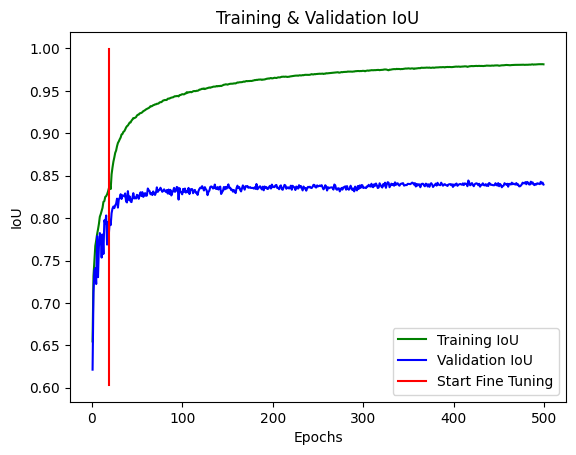

In [4]:
#model_name = 'testlauf_fine_tune_first_layerFalse'
#output_folder_prefix = 'final_runs'

# Zusammenführen von Training- und Fine-Tuning-History
iou = model_history.history['binary_iou']
iou += history_fine.history['binary_iou']

val_iou = model_history.history['val_binary_iou']
val_iou += history_fine.history['val_binary_iou']


# laden des besten models
checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

unet = tf.keras.models.load_model(checkpoint_path, compile= False)
compile_model(unet, learning_rate)


# Evaluieren & Ergebnisse in Tabelle
eval_out = unet.evaluate(test_data_generator)

# Schreiben der Eval-Ergebnisse in csv
with open('../output/final_runs.csv', 'a') as f_object:
    row = []
    
    row.append(model_name)

    for x in eval_out:
        row.append(x)

    # Einfügen der Trainingszeit in Minuten
    row.append(training_time/60)

    # Einfügen der maximalen Val-IoU
    row.append(max(val_iou))

    # Einfügen des Index der maximalen Val-IoU
    row.append(np.argmax(val_iou))

    writer_object = csv.writer(f_object, delimiter= ';')

    writer_object.writerow(row)


# Plotten
epochs = range(1, len(val_iou)+1)

plt.plot(epochs[0:(len(val_iou) - 1)], iou[0:(len(val_iou) - 1)], 'g', label= 'Training IoU')
plt.plot(epochs[0:(len(val_iou) - 1)], val_iou[0:(len(val_iou) - 1)], 'b', label= 'Validation IoU')

plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'r', label='Start Fine Tuning')

plt.title('Training & Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.savefig(f'../output/plots/IoU/iou_{model_name}.png', bbox_inches='tight', dpi= 500)

plt.show()

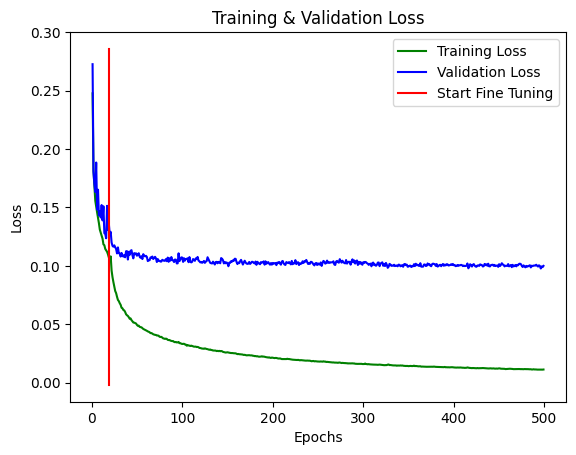

In [5]:
loss = model_history.history['loss']
loss += history_fine.history['loss']

val_loss = model_history.history['val_loss']
val_loss += history_fine.history['val_loss']

plt.plot(epochs[0:(len(val_iou) - 1)], loss[0:(len(val_iou) - 1)], 'g', label= 'Training Loss')
plt.plot(epochs[0:(len(val_iou) - 1)], val_loss[0:(len(val_iou) - 1)], 'b', label= 'Validation Loss')

plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'r', label='Start Fine Tuning')

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'../output/plots/Loss/loss_{model_name}.png', bbox_inches='tight', dpi= 500)

plt.show()

In [6]:
#checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

#unet = tf.keras.models.load_model(checkpoint_path, compile= False)
#compile_model(unet, learning_rate)

# Prognose mit Hilfe des geladenen besten Modells
prediction = unet.predict(test_data_generator)

# Erstellung einer binären Maske aus den wahrscheinlichkeiten, Schwellwert 0.5
out = (prediction > 0.5).astype(np.uint8)

# lediglich halbe Batch Size in eine Abbildung wegen Übersichtlichkeit
rows = int(batch_size / 2)
columns = 3

# Anzahl verfügbarer Batches des Data-Generators
no_of_batches = test_data_generator.__len__()

# Prognose kommt als Tensor mit der Länge der Anzahl der Beispiele
out_idx = 0

# Erstellen des Prognosen-Ordners
if not os.path.isdir(f'../output/predictions/{model_name}'):
    os.makedirs(f'../output/predictions/{model_name}')

# Input und Masken kommen als Batches, über die iteriert wird
for batch_no in range(0, no_of_batches):

    # iterieren über erste Hälfte des Batches
    fig, axs = plt.subplots(rows, columns, figsize=(5, 20))

    for i in range(rows):
        axs[i, 0].imshow(out[out_idx])
        axs[i, 0].set_title('Prediction')

        axs[i, 1].imshow(test_data_generator[batch_no][1][i])
        axs[i, 1].set_title('Truth')

        axs[i, 2].imshow(reverse_scaling(test_data_generator[batch_no][0][i])[:,:,:3])
        axs[i, 2].set_title('Input')

        out_idx += 1

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    plt.savefig(f'../output/predictions/{model_name}/prediction_{model_name}_{batch_no}_I.png', bbox_inches='tight')
    plt.close(fig)

    # iterieren über zweite Hälfte des Batches
    fig, axs = plt.subplots(rows, columns, figsize=(5, 20))

    for i in range(rows):
        axs[i, 0].imshow(out[out_idx])
        axs[i, 0].set_title('Prediction')

        axs[i, 1].imshow(test_data_generator[batch_no][1][rows + i])
        axs[i, 1].set_title('Truth')

        axs[i, 2].imshow(reverse_scaling(test_data_generator[batch_no][0][rows + i])[:,:,:3])
        axs[i, 2].set_title('Input')

        out_idx += 1

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    print(batch_no)
    plt.savefig(f'../output/predictions/{model_name}/prediction_{model_name}_{batch_no}_II.png', bbox_inches='tight', dpi= 400)
    plt.close(fig)

# Zusammenführen der .log-Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
combine_log_files(output_folder_prefix, model_name)

66/66 [==============================] - 9s 120ms/step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


In [7]:
unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 4  0           []                               
                                )]                                                                
                                                                                                  
 split_input (Lambda)           [(None, 224, 224, 1  0           ['input[0][0]']                  
                                ),                                                                
                                 (None, 224, 224, 1                                               
                                ),                                                                
                                 (None, 224, 224, 1                                         

In [32]:
#model_name = "Final_AVG_rgbDrop_0_earlyStop_True_e500"

def combine_log_files():
    # Zusammenführen der .log Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
    filenames = [f'../output/{output_folder_prefix}_logger/{model_name}_I.log', f'../output/{output_folder_prefix}_logger/{model_name}.log']
    with open(f'../output/{output_folder_prefix}_logger/{model_name}.csv', 'w') as outfile:
        # spezifizieren des Delimiters für Excel in erster Zeile
        outfile.write('sep=,\n')

        for i, fname in enumerate(filenames):
            with open(fname) as infile:
                reader = csv.reader(infile)

                for j, row in enumerate(reader):
                    # überspringen des 2. Headers
                    if i == 1 and j == 0:
                        continue

                    delimiter = ','
                    list_to_string = delimiter.join(row)
                    list_to_string += '\n'

                    outfile.write(list_to_string)

In [14]:
with open(f'../output/{output_folder_prefix}_logger/{model_name}_I.log') as infile:
    reader = csv.reader(infile)
    for i, row in enumerate(reader):
        if i == 0:
            continue
        print(row)

['0', '0.7961242198944092', '0.6587730646133423', '20309084.0', '44833484.0', '0.24731293320655823', '0.7116237282752991', '0.8449028730392456', '143743008.0', '110635216.0', '0.8323593139648438', '0.7104504108428955', '6571040.0', '11194135.0', '0.19853559136390686', '0.7745783925056458', '0.8540922403335571', '49742008.0', '38464532.0']
['1', '0.8555810451507568', '0.7428621053695679', '19262012.0', '26882816.0', '0.17415392398834229', '0.8062108755111694', '0.8530752658843994', '161536704.0', '111839176.0', '0.8509215116500854', '0.7363330125808716', '7721061.0', '8077029.0', '0.17862582206726074', '0.8224303126335144', '0.8289172649383545', '52764112.0', '37409496.0']
['2', '0.868036687374115', '0.7619959115982056', '18203548.0', '23961460.0', '0.15954600274562836', '0.8248876929283142', '0.8611232042312622', '164482416.0', '112873368.0', '0.855846107006073', '0.7469853162765503', '3632307.0', '11643931.0', '0.15823477506637573', '0.7808046936988831', '0.9194782376289368', '4921813

In [158]:
unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 4  0           []                               
                                )]                                                                
                                                                                                  
 split_input (Lambda)           [(None, 224, 224, 1  0           ['input[0][0]']                  
                                ),                                                                
                                 (None, 224, 224, 1                                               
                                ),                                                                
                                 (None, 224, 224, 1                                         

In [12]:
unet.save(f'{model_name}.h5')